In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import mysql.connector
from datetime import datetime
import warnings
from scipy import stats

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)
plt.figure(figsize=(10, 8))  # Increase figure size for better readability
sns.set_style("whitegrid")

BOLD = '\033[1m'
BLUE = '\033[94m'
RESET = '\033[0m'

<Figure size 1000x800 with 0 Axes>

In [4]:
host = 'localhost'
user = 'root'
password = 'Test@1234'
database = 'github'

# Establish connection
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

In [5]:
rate_query = """
            SELECT r.repo_id, r.langauge, r.has_ci_cd, r.num_collaborators, 
            c.total_code_change / c.num_commits AS code_rate_by_commits,
            c.total_code_change / CASE WHEN r.num_collaborators = 0 THEN 1 ELSE r.num_collaborators END AS code_rate_by_collab,
            c.num_commits / c.num_days velocity
            FROM repositories r
            INNER JOIN (
            SELECT repo_id, COUNT(messages) AS num_commits, SUM(num_files_changed) AS total_code_change,
             MIN(commit_date) AS first_commit, MAX(commit_date) AS last_commit,
             DATEDIFF(MAX(commit_date), MIN(commit_date)) +1 AS num_days
            FROM commit_messages
            GROUP BY repo_id
            ) as c
            ON r.repo_id = c.repo_id

"""

df_rate = pd.read_sql(rate_query, connection)
num_repos = df_rate.shape[0]
label_map = {0: 'No CI/CD', 1: 'CI/CD Implemented'}

# Replace values in the DataFrame
df_rate['ci_cd_label'] = df_rate['has_ci_cd'].replace(label_map)


## Repo Information

- Total repos = 2554
    * ci_cd implemented = 425
    * ci_cd not implemented = 2129
- Total no of commits = 993871
- Total no of messages in English = 852461

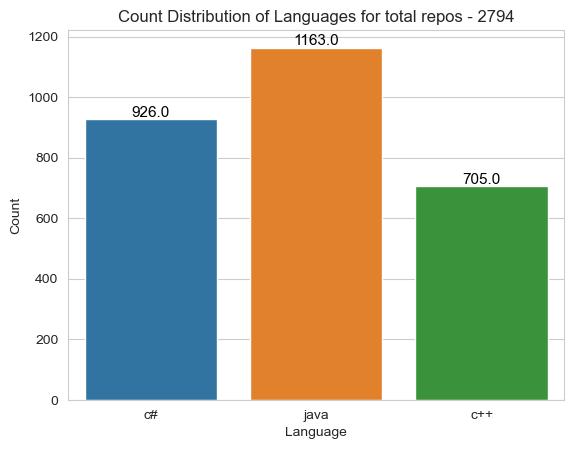

In [6]:
ax = sns.countplot(data=df_rate, x='langauge')
plt.title(f'Count Distribution of Languages for total repos - {num_repos}')
plt.xlabel('Language')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.savefig('Repos.jpeg')
plt.show()

In [7]:
# Below code checks if there is any null value

mask = df_rate.isnull().any(axis=1)

df_rate[mask]

,repo_id,langauge,has_ci_cd,num_collaborators,code_rate_by_commits,code_rate_by_collab,velocity,ci_cd_label


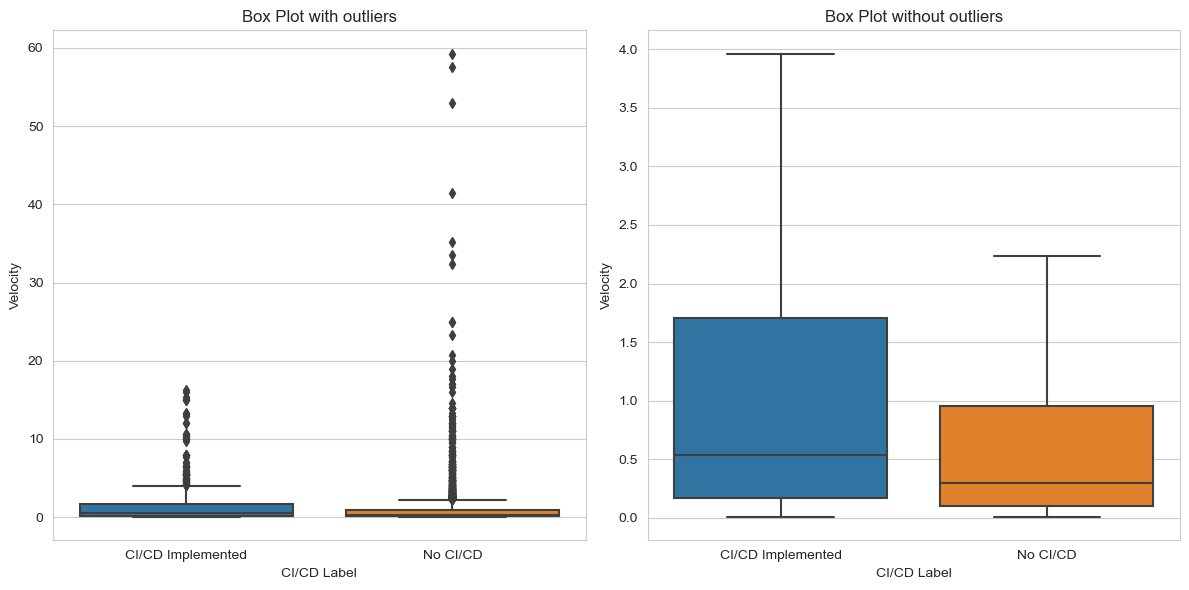

                       mean  <lambda_0>
ci_cd_label                            
CI/CD Implemented  1.666589     1.53245
No CI/CD           1.231928     0.85695
T-Statistic: 2.4920786028600315
P-Value: 0.012757373728214168
Reject null hypothesis: There is a significant difference in mean velocity between the two groups.


In [8]:
grouped_stats = df_rate.groupby('ci_cd_label')['velocity'].agg(['mean', lambda x: x.quantile(0.75) - x.quantile(0.25)])

# Create two separate plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with fliers
sns.boxplot(x='ci_cd_label', y='velocity', data=df_rate, showfliers=True, ax=axes[0])
axes[0].set_xlabel('CI/CD Label')
axes[0].set_ylabel('Velocity')
axes[0].set_title('Box Plot with outliers')
# Get the maximum x position
# max_x_position = len(df_rate['ci_cd_label'].unique()) - 1

# # Add mean and IQR to the plot
# for label, (mean, iqr) in grouped_stats.iterrows():
#     x_position = df_rate['ci_cd_label'].unique().tolist().index(label)
#     axes[0].text(max_x_position, mean, f'Mean: {mean:.2f}\nIQR: {iqr:.2f}', ha='right', va='center', fontweight='bold', fontsize=12, color='black')


# Plot without fliers
sns.boxplot(x='ci_cd_label', y='velocity', data=df_rate, showfliers=False, ax=axes[1])
axes[1].set_xlabel('CI/CD Label')
axes[1].set_ylabel('Velocity')
axes[1].set_title('Box Plot without outliers')

# # Add mean and IQR to the plot
# for label, (mean, iqr) in grouped_stats.iterrows():
#     x_position = df_rate['ci_cd_label'].unique().tolist().index(label)
#     axes[1].text(x_position, mean, f'Mean: {mean:.2f}\nIQR: {iqr:.2f}', fontweight='bold', fontsize=12, color='black')

plt.tight_layout()
plt.savefig('Velocity.jpeg')
plt.show()
print(grouped_stats)

# Filter data for CI/CD Implemented and No CI/CD groups
ci_cd_implemented_data = df_rate[df_rate['ci_cd_label'] == 'CI/CD Implemented']['velocity']
no_ci_cd_data = df_rate[df_rate['ci_cd_label'] == 'No CI/CD']['velocity']

# Perform t-test
t_statistic, p_value = stats.ttest_ind(ci_cd_implemented_data, no_ci_cd_data)

# Print results
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in mean velocity between the two groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in mean velocity between the two groups.")

1. __Mean Velocity:__

For the "CI/CD Implemented" group, the mean velocity is higher (approximately 1.67) compared to the "No CI/CD" group (approximately 1.19). This suggests that projects with CI/CD implemented tend to have higher average velocity.

2. __Interquartile Range (IQR):__

The IQR for the "CI/CD Implemented" group (approximately 1.53) is higher than that of the "No CI/CD" group (approximately 0.84). This indicates that the spread of velocity values within the "CI/CD Implemented" group is wider than within the "No CI/CD" group.

3. __Conclusion:__
Projects with CI/CD implemented generally have higher average velocity, indicating potentially faster development or deployment cycles. However, there is also greater variability in velocity within these projects, as evidenced by the wider interquartile range. This suggests that while CI/CD implementation may lead to higher velocity on average, individual project velocities may vary more widely compared to projects without CI/CD.

Overall, this analysis suggests a positive association between CI/CD implementation and velocity, but it also highlights the need for careful consideration of factors contributing to velocity variability within projects.

In [9]:
grouped_stats = df_rate.groupby('ci_cd_label')['velocity'].agg(['mean', 'std'])

# Merge the mean and standard deviation back to the original DataFrame
df_rate = df_rate.merge(grouped_stats, left_on='ci_cd_label', right_index=True)

# Calculate Z-Score normalized velocity
df_rate['z_score_normalized_velocity'] = (df_rate['velocity'] - df_rate['mean']) / df_rate['std']


grouped_stats = df_rate.groupby('ci_cd_label')['z_score_normalized_velocity'].agg(['mean', 'std'])

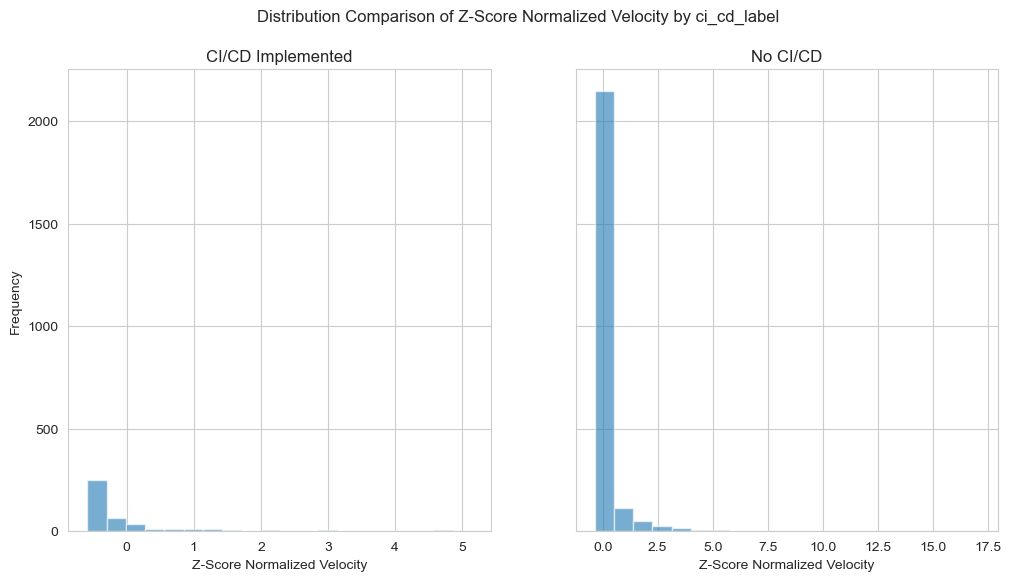

In [10]:

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (label, group) in zip(axs, df_rate.groupby('ci_cd_label')):
    ax.hist(group['z_score_normalized_velocity'], bins=20, alpha=0.6)
    ax.set_title(label)
    ax.set_xlabel('Z-Score Normalized Velocity')
    ax.grid(True)

axs[0].set_ylabel('Frequency')
plt.suptitle('Distribution Comparison of Z-Score Normalized Velocity by ci_cd_label')
plt.show()

In [11]:
df_ci_cd = df_rate[df_rate['ci_cd_label'] == 'CI/CD Implemented'] 
df_no_ci_cd = df_rate[df_rate['ci_cd_label'] == 'No CI/CD'] 
correlation = df_ci_cd['velocity'].corr(df_ci_cd['num_collaborators'])
print(f"Correlation coefficient for CI/CD Implemented: {correlation}")

correlation = df_no_ci_cd['velocity'].corr(df_no_ci_cd['num_collaborators'])
print(f"Correlation coefficient for No CI/CD Implemented: {correlation}")

Correlation coefficient for CI/CD Implemented: 0.024566433262212195
Correlation coefficient for No CI/CD Implemented: 0.04537491009361225


In [12]:
df_has_cicd = df_rate[df_rate['has_ci_cd'] == 1]
df_no_ci_cd = df_rate[df_rate['has_ci_cd'] == 0]

In [13]:
sns.set(style = 'ticks')

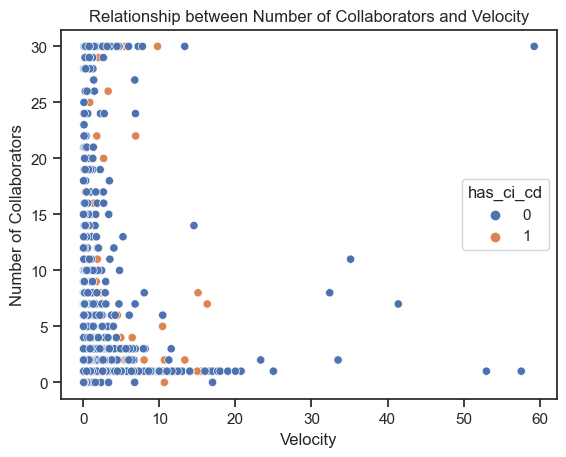

In [14]:
sns.scatterplot(data=df_rate, x='velocity', y='num_collaborators', hue='has_ci_cd')
plt.xlabel('Velocity')
plt.ylabel('Number of Collaborators')
plt.title('Relationship between Number of Collaborators and Velocity')
plt.show()

In [15]:
df_rate.head()

,repo_id,langauge,has_ci_cd,num_collaborators,code_rate_by_commits,code_rate_by_collab,velocity,ci_cd_label,mean,std,z_score_normalized_velocity
0,1,c#,1,30,0.0,0.0,1.1711,CI/CD Implemented,1.666589,2.845453,-0.174134
2,3,c#,1,17,0.0,0.0,0.2677,CI/CD Implemented,1.666589,2.845453,-0.491623
13,14,c#,1,1,0.0,0.0,0.2188,CI/CD Implemented,1.666589,2.845453,-0.508808
20,21,c#,1,1,0.0,0.0,0.0619,CI/CD Implemented,1.666589,2.845453,-0.563949
45,46,c#,1,2,0.0,0.0,0.1861,CI/CD Implemented,1.666589,2.845453,-0.520300


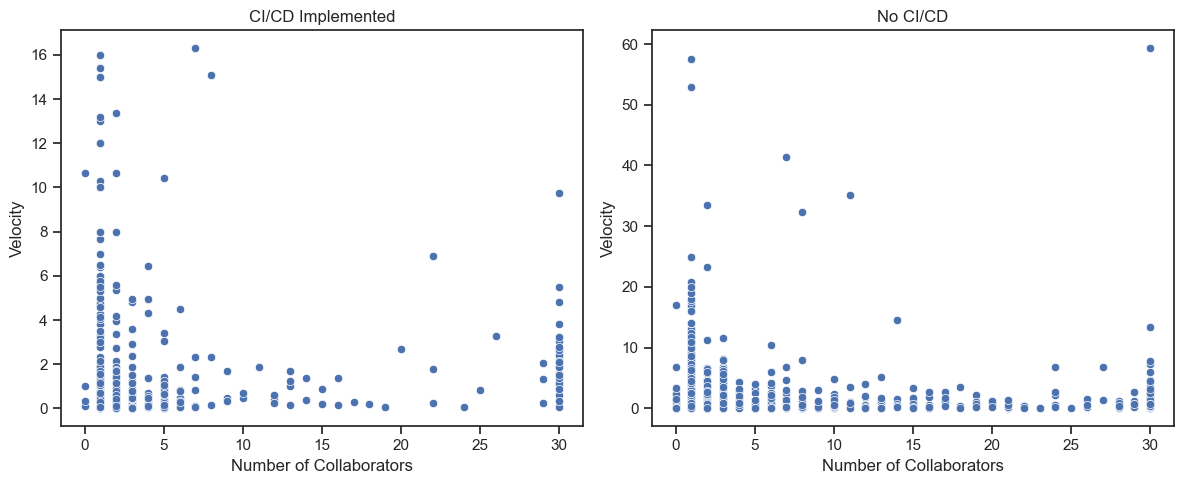

In [16]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=df_has_cicd, x='num_collaborators', y='velocity', ax=axes[0])
axes[0].set_title('CI/CD Implemented')
axes[0].set_xlabel('Number of Collaborators')
axes[0].set_ylabel('Velocity')

# Plot scatter plot for has_ci_cd = 1
sns.scatterplot(data=df_no_ci_cd, x='num_collaborators', y='velocity', ax=axes[1])
axes[1].set_title('No CI/CD')
axes[1].set_xlabel('Number of Collaborators')
axes[1].set_ylabel('Velocity')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

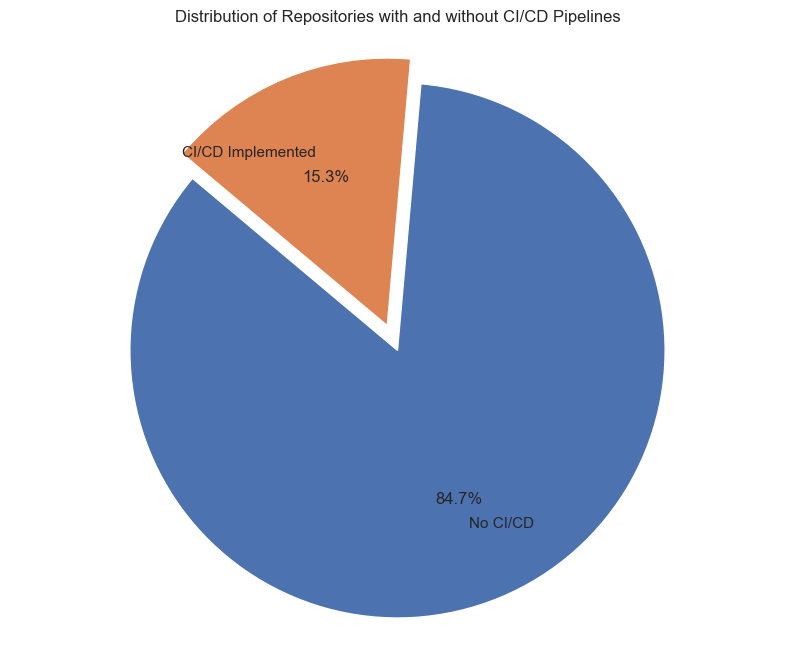

In [17]:
ci_cd_counts = df_rate['ci_cd_label'].value_counts()

# Plot pie chart
plt.figure(figsize=(10, 8))  # Increase figure size for better readability
sns.set_style("whitegrid")

# Explode the slices slightly
explode = (0.05, 0.05)

# Set label distance closer to the pie
label_distance = 0.7

plt.pie(ci_cd_counts, labels=ci_cd_counts.index, autopct='%1.1f%%', startangle=140, explode=explode, labeldistance=label_distance)

plt.title('Distribution of Repositories with and without CI/CD Pipelines')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('ci_cd_pct.jpeg')
plt.show()

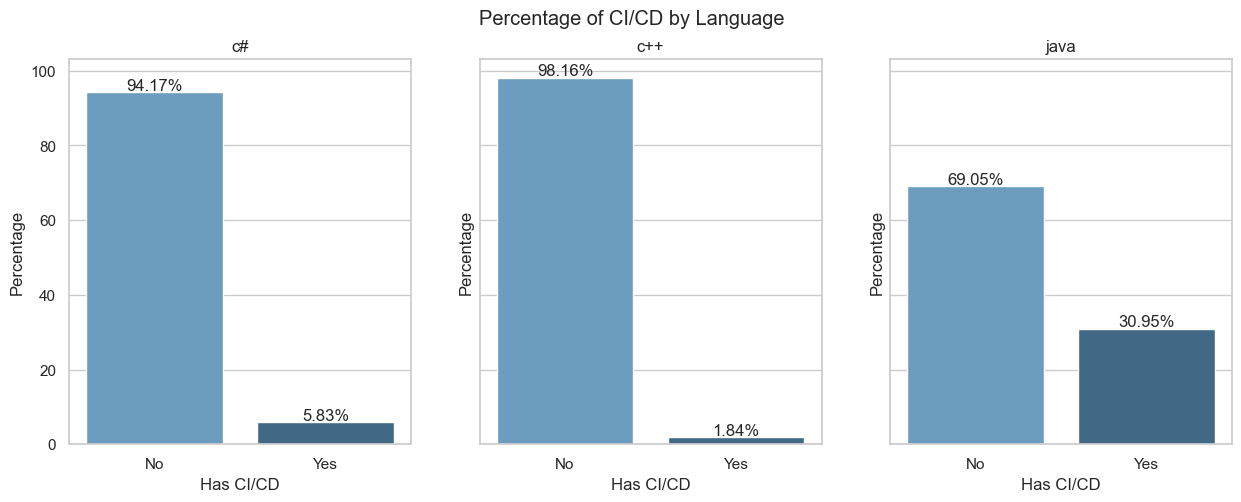

In [18]:
# Calculate percentage of has_ci_cd for each language
percentage_df = df_rate.groupby(['langauge', 'has_ci_cd']).size().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Plotting pie charts for each language
fig, axes = plt.subplots(nrows=1, ncols=len(df_rate['langauge'].unique()), figsize=(15, 5), sharey=True)
fig.suptitle('Percentage of CI/CD by Language')

for i, lang in enumerate(df_rate['langauge'].unique()):
    sns.barplot(x=percentage_df.columns.map({0: 'No', 1: 'Yes'}), y=percentage_df.loc[lang], palette="Blues_d", ax=axes[i])
    axes[i].set_title(lang)
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('Has CI/CD')
    # Annotating each bar with its respective percentage
    for p in axes[i].patches:
        axes[i].annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# plt.tight_layout()
plt.savefig('lang_pct.jpeg')
plt.show()

# RQ2. 



In [19]:
rq2_query = """
            SELECT bug.repo_id, bug.langauge, bug.num_collaborators, bug.has_ci_cd,
            bug.num_bug_fix , message.num_commits ,
            bug.num_bug_fix / message.num_commits bug_rate
            FROM (
                    SELECT r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd,COUNT(c.all_category) num_bug_fix
                    FROM repositories r
                    INNER JOIN commit_message_category c
                        ON r.repo_id = c.repo_id
                    WHERE c.all_category = 'Bug Fixes' 
                    GROUP BY r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd
            ) bug
            INNER JOIN (
                    SELECT repo_id,  COUNT(messages) num_commits
                    FROM commit_messages
                    WHERE  messages REGEXP '^[A-Za-z0-9[:space:][:punct:]]*$'
                    GROUP BY repo_id
            ) message
            ON bug.repo_id = message.repo_id  
""" 
df_bug = pd.read_sql(rq2_query, connection)
# Replace values in the DataFrame
df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
df_bug.rename(columns={'langauge': 'language'}, inplace=True)
df_bug.head(-5)

,repo_id,language,num_collaborators,has_ci_cd,num_bug_fix,num_commits,bug_rate,ci_cd_label
0,1,c#,30,1,559,3988,0.1402,CI/CD Implemented
1,2,c#,4,0,7,37,0.1892,No CI/CD
2,3,c#,17,1,68,1107,0.0614,CI/CD Implemented
3,4,c#,6,0,31,1008,0.0308,No CI/CD
4,5,c#,4,0,11,210,0.0524,No CI/CD
...,...,...,...,...,...,...,...,...
1929,2586,c++,1,0,1,25,0.0400,No CI/CD
1930,2743,c++,1,0,1,124,0.0081,No CI/CD
1931,2706,c++,2,0,2,191,0.0105,No CI/CD
1932,2615,c++,2,0,4,52,0.0769,No CI/CD


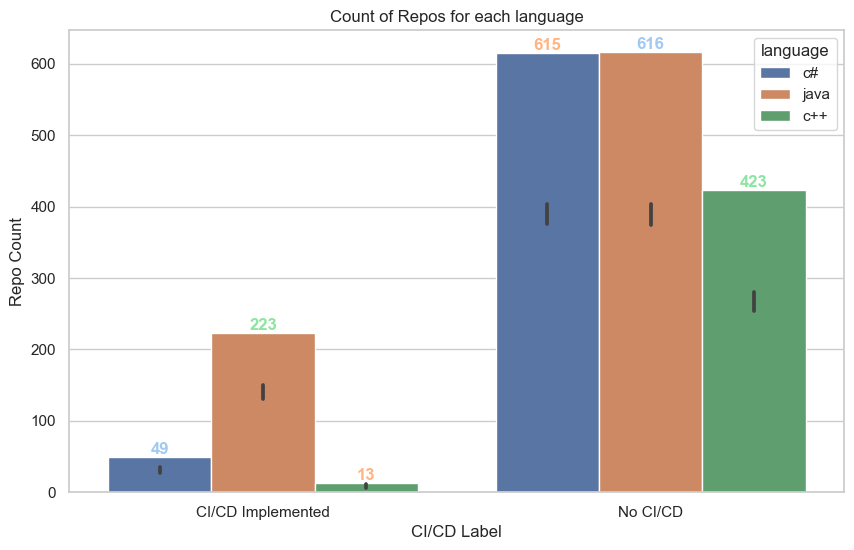

In [20]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='ci_cd_label', y='repo_id', hue='language', data=df_bug, estimator=lambda x: len(set(x)))
plt.xlabel('CI/CD Label')
plt.ylabel('Repo Count')
plt.title('Count of Repos for each language')

# Annotate count values on top of each bar
for i, p in enumerate(ax.patches):
    hue_index = i % len(df_bug['language'].unique())
    plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.1, str(int(p.get_height())), ha='center', va='bottom', fontweight='bold', color=sns.color_palette('pastel')[hue_index])

plt.xticks(rotation=0)
# plt.tight_layout
plt.savefig('Bug_Repo_Count.jpeg')
plt.show()

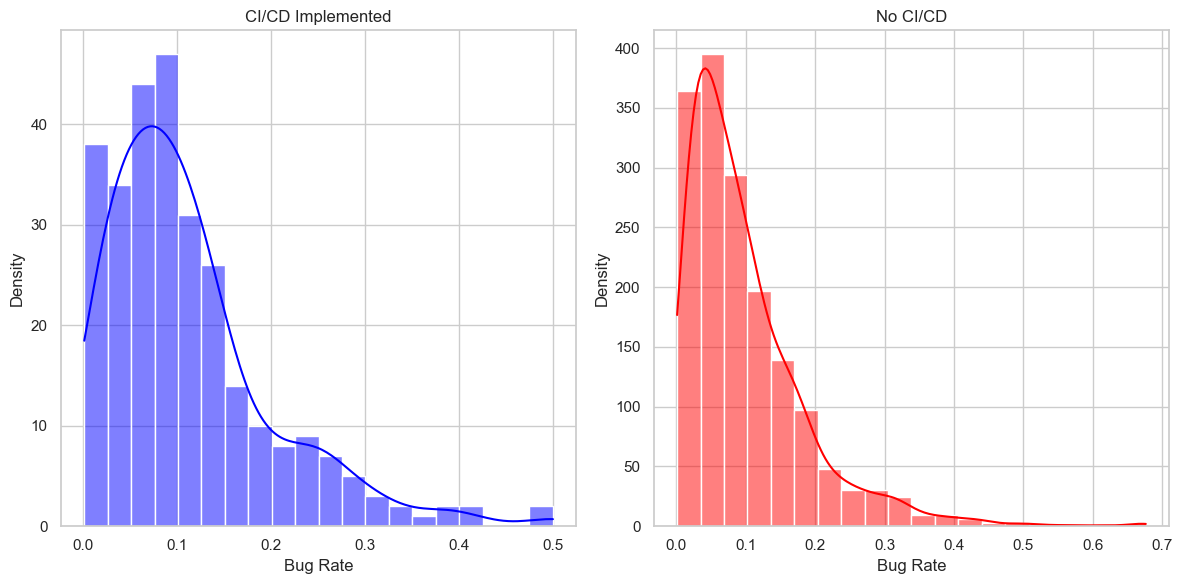

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  285.000000   285.000000    285.000000
mean     0.111678   125.091228    931.252632
std      0.089000   393.100217   2701.701326
min      0.001400     1.000000     10.000000
25%      0.050700     3.000000     54.000000
50%      0.090900    12.000000    163.000000
75%      0.140200    55.000000    524.000000
max      0.500000  3795.000000  30621.000000
No CI/CD
          bug_rate  num_bug_fix   num_commits
count  1654.000000  1654.000000   1654.000000
mean      0.099286    43.250907    384.068924
std       0.087457   154.855229   1050.921342
min       0.001100     1.000000      3.000000
25%       0.038025     2.000000     44.000000
50%       0.076900     6.000000    101.500000
75%       0.133300    21.750000    289.750000
max       0.676500  2763.000000  14584.000000
Shapiro-Wilk Test p-value for CI/CD Implemented: 1.408229713666543e-14
Shapiro-Wilk Test p-value for No CI/CD: 5.175524919571064e-39


In [21]:
ci_cd_implemented = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
no_ci_cd = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

# Plotting separate graphs
plt.figure(figsize=(12, 6))

# Plot for CI/CD Implemented
plt.subplot(1, 2, 1)
sns.histplot(ci_cd_implemented['bug_rate'], bins=20, color='blue', kde=True)
plt.xlabel('Bug Rate')
plt.ylabel('Density')
plt.title('CI/CD Implemented')

# Plot for No CI/CD
plt.subplot(1, 2, 2)
sns.histplot(no_ci_cd['bug_rate'], bins=20, color='red', kde=True)
plt.xlabel('Bug Rate')
plt.ylabel('Density')
plt.title('No CI/CD')

plt.tight_layout()
plt.savefig('rq2.jpeg')
plt.show()

ci_cd_shapiro = stats.shapiro(ci_cd_implemented['bug_rate'])
no_ci_cd_shapiro = stats.shapiro(no_ci_cd['bug_rate'])


print('='*75)
print(f'{BOLD}{BLUE}CI/CD Implemented{RESET}')
print(ci_cd_implemented[['bug_rate','num_bug_fix','num_commits']].describe())

print(f'{BOLD}{BLUE}No CI/CD{RESET}')
print(no_ci_cd[['bug_rate','num_bug_fix','num_commits']].describe())
print('='*75)


print("Shapiro-Wilk Test p-value for CI/CD Implemented:", ci_cd_shapiro[1])
print("Shapiro-Wilk Test p-value for No CI/CD:", no_ci_cd_shapiro[1])

### Hypothesis testing

In both cases, the p-values are much smaller than the typical significance level of 0.05. Therefore, we would likely reject the null hypothesis and conclude that the bug rate data in both groups does not follow a normal distribution.

- __Which hypothesis test performed or why?__ We performed T test because we are comparing two groups one CI/CD implemented another is NO_CI/CD implemented. Second reason is we dont know the standard deviation of population.

We are performing one tailed hypotesis as we are only validating wheather implementation of CI/CD helps in reducing errors.Hence we are focusing on one direction of the comparison – whether bug rates are lower for repositories with CI/CD compared to those without. 

For my analysis 5% as significance level for below null hypothesis and alternate hypothesis. 


- __Null Hypothesis (H0):__ There is NO significant difference in bug rates between repositories with and without CI/CD adoption.

- __Alternative Hypothesis (H1):__ There is A significant difference in bug rates between repositories with and without CI/CD adoption.

In [22]:
ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
no_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

# Perform t-test
t_stat, p_value = stats.ttest_ind(ci_cd_group['bug_rate'], no_ci_cd_group['bug_rate'], equal_var=False)

# Print results
print("T-Statistic:", t_stat)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is A significant difference in bug rates between repositories with and without CI/CD adoption.")
else:
    print("Fail to reject the null hypothesis. There is NO significant difference in bug rates between repositories with and without CI/CD adoption.")

T-Statistic: 2.176592038641123
P-value: 0.030118865045797097
Reject the null hypothesis. There is A significant difference in bug rates between repositories with and without CI/CD adoption.


In [23]:
# Define the list of language columns
language_columns = df_bug['language'].unique().tolist()  # Add all language columns

df_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
df_no_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

# Iterate through each language column
for language_column in language_columns:
    print('-'*50)
    ci_cd_group = df_ci_cd_group[df_ci_cd_group['language'] == language_column]
    no_ci_cd_group = df_no_ci_cd_group[df_no_ci_cd_group['language'] == language_column]
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(ci_cd_group['bug_rate'], no_ci_cd_group['bug_rate'], equal_var=False)
    
    # Print results
    print("Language:", language_column)
    print("T-Statistic:", t_stat)
    print("P-value:", p_value)
    
    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and non-adopted repositories for language", language_column)
    else:
        print("Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adopted and non-adopted repositories for language", language_column)
    
    print('-'*50)

--------------------------------------------------
Language: c#
T-Statistic: 0.4485108148875404
P-value: 0.6554793478794617
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adopted and non-adopted repositories for language c#
--------------------------------------------------
--------------------------------------------------
Language: java
T-Statistic: 2.413854046616884
P-value: 0.016282300623200886
Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and non-adopted repositories for language java
--------------------------------------------------
--------------------------------------------------
Language: c++
T-Statistic: 2.642731964975051
P-value: 0.02022221527077833
Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and non-adopted repositories for language c++
--------------------------------------------------


#### __Conclusion:__

Based on the statistical analysis, we conclude that there is a significant difference in bug rates between repositories with CI/CD adoption and repositories without CI/CD adoption. Therefore, it appears that the implementation of CI/CD practices correlates with a reduction in bugs in open-source repositories. This suggests that CI/CD practices may indeed contribute to improving software quality by reducing the occurrence of bugs.


Despite the mean bug rate for repositories with CI/CD implementation being higher (0.111678) compared to repositories without CI/CD (0.099286), the hypothesis test results suggest that there is a statistically significant difference in bug rates between the two groups.

The hypothesis test indicates that the difference in bug rates is unlikely to have occurred by random chance alone. Thus, even though the mean bug rate for repositories with CI/CD implementation is higher, the hypothesis test suggests that the adoption of CI/CD is associated with a lower bug rate compared to repositories without CI/CD.

Therefore, the conclusion remains the same: repositories with CI/CD adoption exhibit a lower bug rate compared to repositories without CI/CD adoption.


If the CI/CD implemented group has a higher bug rate compared to the group without CI/CD, it may initially seem counterintuitive to conclude that CI/CD adoption has an impact on reducing bug rates. However, there could be several factors at play that explain this apparent contradiction:

1. Increased Bug Detection: CI/CD pipelines often include automated testing processes that detect bugs early in the development cycle. This means that bugs are identified and fixed more frequently, resulting in a higher number of bug fixes. While this may lead to a higher bug rate metric, it also indicates that more bugs are being caught and addressed before they reach production, ultimately resulting in a more stable and reliable software product.

2. Enhanced Development Velocity: CI/CD practices promote rapid and continuous delivery of code changes. This faster pace of development may lead to more frequent deployments, which in turn can increase the likelihood of introducing bugs. However, the iterative nature of CI/CD allows for quicker identification and resolution of these bugs, ultimately resulting in a more resilient codebase over time.

3. Improved Code Quality: Although the bug rate metric may be higher in the CI/CD implemented group, it's important to consider other quality indicators such as code coverage, code complexity, and overall code health. CI/CD practices often emphasize code quality through automated code analysis, code reviews, and continuous integration. While some bugs may still occur, the overall quality of the codebase may be higher in CI/CD environments.

4. Long-Term Benefits: While the immediate bug rate may be higher in the CI/CD implemented group, the long-term trend may show a reduction in bugs over time as the development team iteratively improves their processes and refines their CI/CD pipelines. This iterative improvement cycle leads to continuous optimization and refinement of the software development process, ultimately resulting in fewer bugs and higher-quality software releases.

5. Continuous Improvement: The primary goal of CI/CD is to automate and streamline the software delivery process, enabling faster and more frequent releases. While CI/CD practices can catch bugs earlier in the development cycle and facilitate rapid bug fixes, their effectiveness depends on how well they are implemented and integrated into the development workflow.

6. Feedback Loops: CI/CD setups often include automated testing, which provides rapid feedback to developers about the quality of their code. This feedback loop can help identify and address bugs more quickly, potentially reducing the overall bug rate over time.

7. Automated Testing: CI/CD pipelines typically include automated testing stages where various types of tests (unit tests, integration tests, regression tests, etc.) are executed automatically upon each code change. These tests help catch bugs early in the development process, reducing the likelihood of bugs reaching production.

8. Continuous Integration: CI systems automatically integrate code changes into a shared repository multiple times a day. This frequent integration allows developers to identify and fix integration issues quickly, preventing the accumulation of bugs over time.

9. Continuous Deployment: With CD, the process of deploying code changes to production is automated. This automation ensures that only thoroughly tested and bug-free code reaches production environments, reducing the chances of introducing new bugs during deployment.

10. Quick Feedback Loop: CI/CD pipelines provide quick feedback to developers about the quality of their code changes. If a bug is introduced, developers are alerted promptly, allowing them to fix the issue before it progresses further.

11. Version Control: CI/CD practices often enforce version control best practices, such as using feature branches and pull requests. These practices make it easier to track changes, review code, and revert changes if necessary, reducing the likelihood of introducing new bugs.

12. Consistent Environment: CI/CD pipelines typically use standardized environments for testing and deployment. This consistency helps identify and address environment-specific bugs early in the development process.

In summary, while the initial bug rate may appear higher in repositories with CI/CD adoption, the overall impact on reducing bug rates is attributed to the early bug detection, enhanced development velocity, improved code quality, and long-term benefits associated with CI/CD practices.


# RQ3: 

1: started for Integration Errors


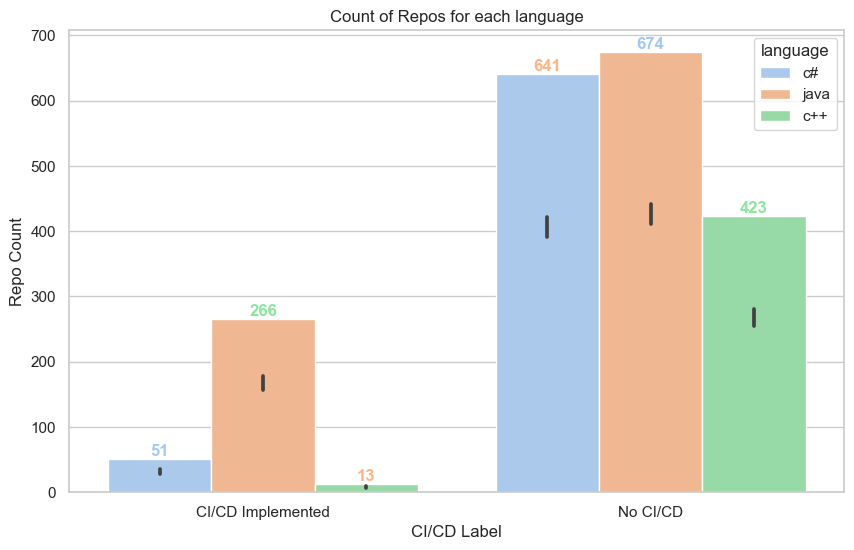

<Figure size 640x480 with 0 Axes>

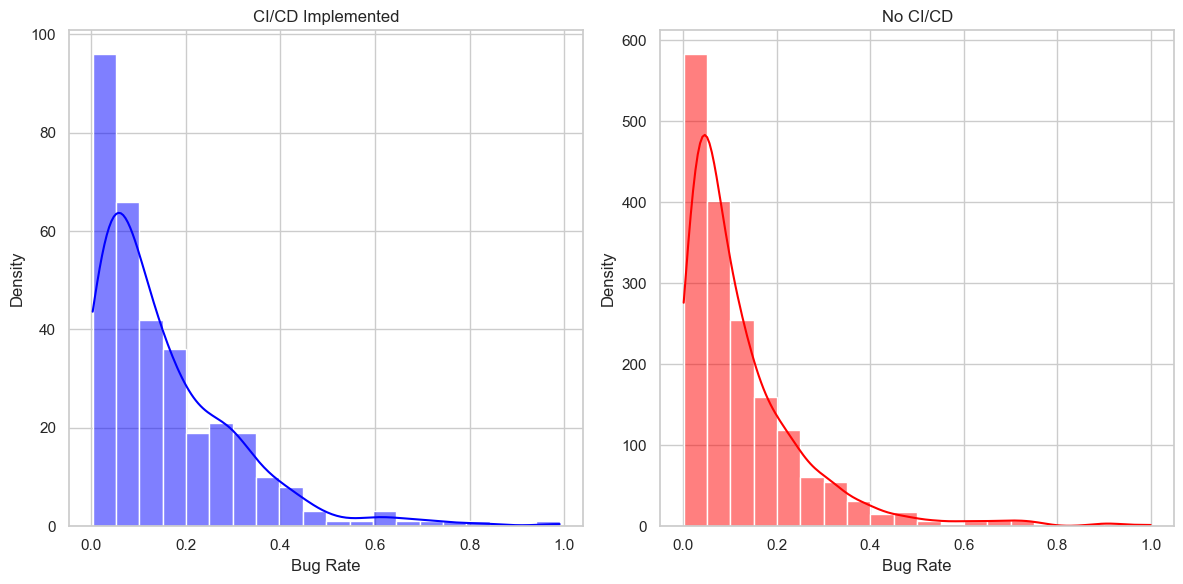

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  330.000000   330.000000    330.000000
mean     0.154256   136.518182    806.524242
std      0.149564   476.269356   2518.581128
min      0.003300     1.000000      5.000000
25%      0.045500     3.000000     45.000000
50%      0.107100    12.000000    135.500000
75%      0.221775    54.750000    449.750000
max      0.990300  4977.000000  30621.000000
No CI/CD
          bug_rate  num_bug_fix   num_commits
count  1738.000000  1738.000000   1738.000000
mean      0.127130    52.733026    369.156502
std       0.135673   207.733655   1027.447173
min       0.000500     1.000000      1.000000
25%       0.038500     2.000000     42.000000
50%       0.080800     7.000000     98.000000
75%       0.168725    25.750000    278.750000
max       1.000000  3455.000000  14584.000000
T-Statistic: 3.0639780912330257
P-value: 0.002319045092925855
Reject the null hypothesis. There is A significant difference in bug rates between CI/CD ado

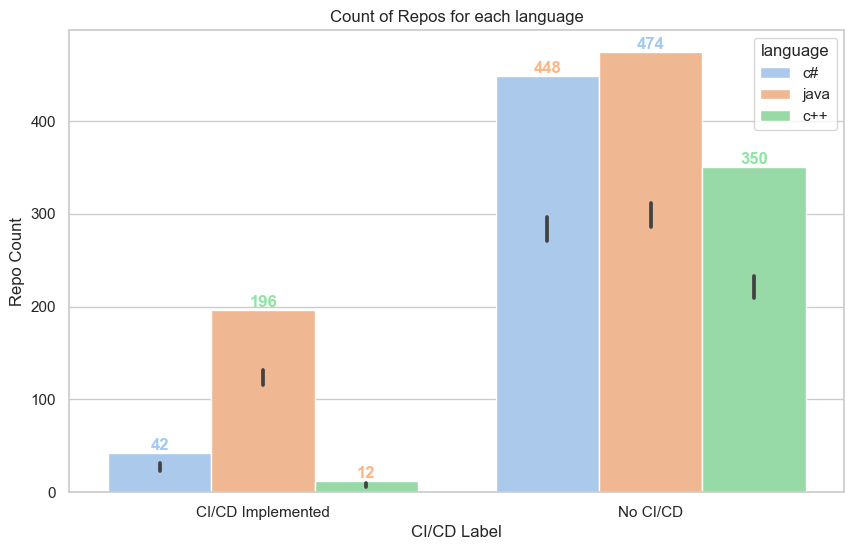

<Figure size 640x480 with 0 Axes>

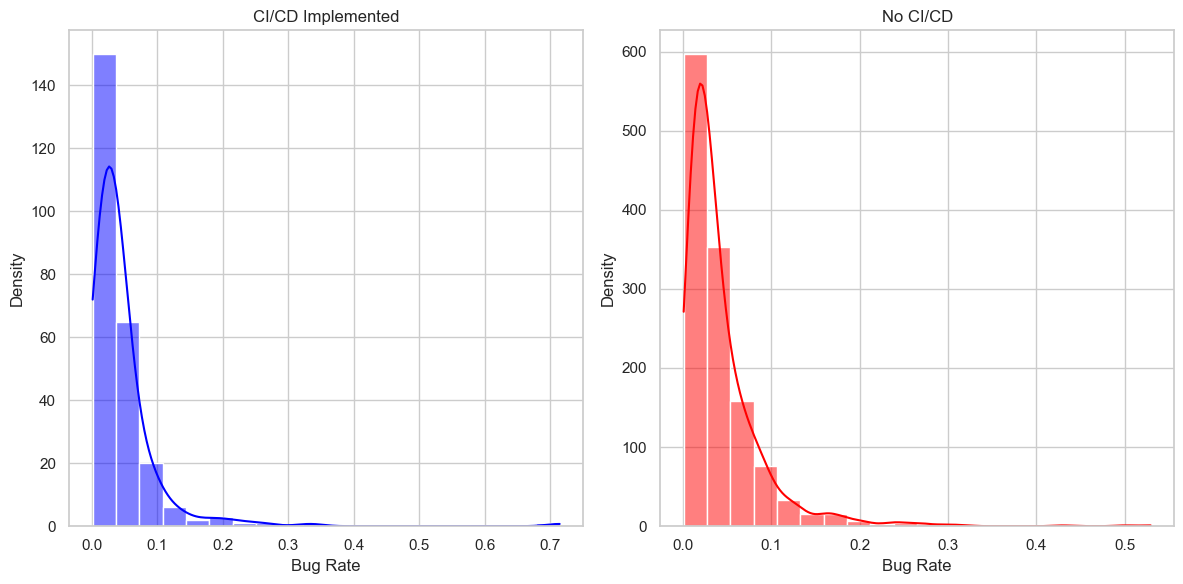

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  250.000000    250.00000    250.000000
mean     0.044686     39.53200   1047.936000
std      0.060795    137.05799   2865.787497
min      0.001300      1.00000      8.000000
25%      0.016250      1.00000     77.000000
50%      0.031000      5.00000    197.000000
75%      0.049850     19.00000    649.500000
max      0.714300   1448.00000  30621.000000
No CI/CD
          bug_rate  num_bug_fix   num_commits
count  1272.000000  1272.000000   1272.000000
mean      0.043417    15.548742    472.034591
std       0.047124    55.671376   1181.139411
min       0.000900     1.000000      8.000000
25%       0.015900     1.000000     55.000000
50%       0.029150     3.000000    129.500000
75%       0.054100    11.000000    378.000000
max       0.529400  1333.000000  14584.000000
T-Statistic: 0.3121308249198568
P-value: 0.7551506466078136
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI

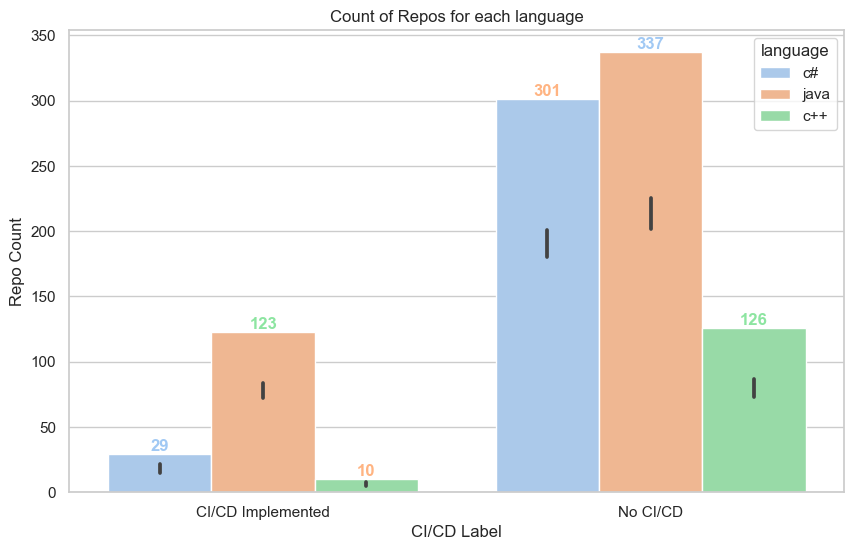

<Figure size 640x480 with 0 Axes>

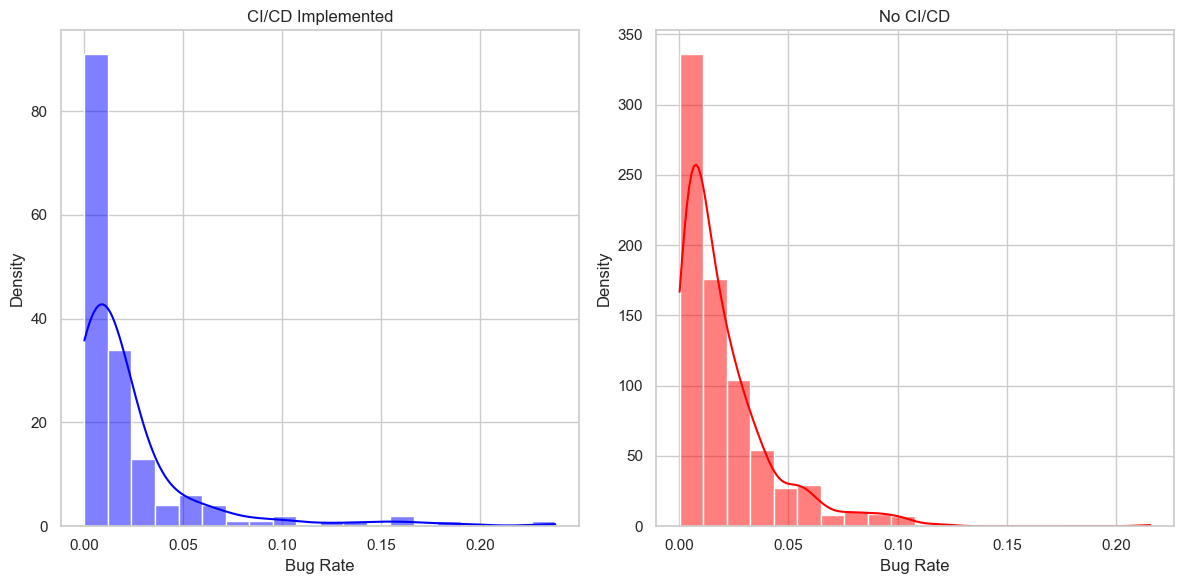

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  162.000000   162.000000    162.000000
mean     0.022306    12.419753   1523.679012
std      0.035497    30.536757   3466.609453
min      0.000200     1.000000      8.000000
25%      0.004725     1.000000    121.250000
50%      0.009900     3.000000    347.000000
75%      0.022575     8.000000   1447.000000
max      0.238100   281.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  764.000000   764.000000    764.000000
mean     0.020833     6.541885    671.106021
std      0.022210    16.935993   1468.718566
min      0.000200     1.000000     10.000000
25%      0.005975     1.000000     74.750000
50%      0.013650     2.000000    193.000000
75%      0.027725     5.000000    604.250000
max      0.215600   286.000000  14584.000000
T-Statistic: 0.507532968637949
P-value: 0.6123740149549879
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopte

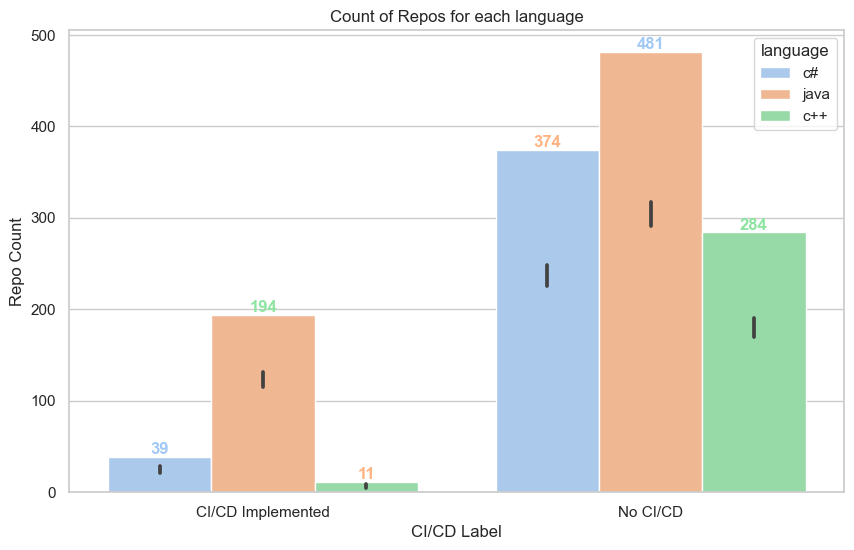

<Figure size 640x480 with 0 Axes>

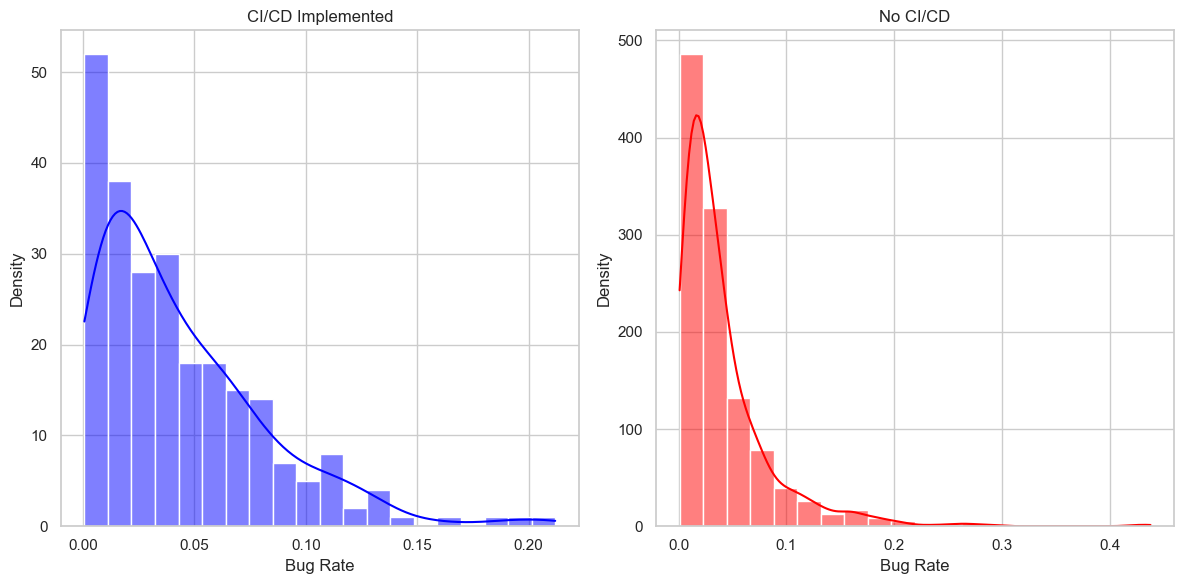

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  244.000000   244.000000    244.000000
mean     0.043480    38.012295   1071.696721
std      0.038173   133.949425   2896.939384
min      0.000600     1.000000      7.000000
25%      0.014250     2.000000     67.500000
50%      0.032850     5.000000    208.500000
75%      0.062825    17.250000    656.500000
max      0.211900  1408.000000  30621.000000
No CI/CD
          bug_rate  num_bug_fix   num_commits
count  1139.000000  1139.000000   1139.000000
mean      0.040339    16.792801    517.967515
std       0.043489    46.627653   1239.231932
min       0.000900     1.000000      5.000000
25%       0.013200     1.000000     66.000000
50%       0.027000     3.000000    147.000000
75%       0.050000    10.000000    447.500000
max       0.437500   613.000000  14584.000000
T-Statistic: 1.1371768972406355
P-value: 0.2561617003821945
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI

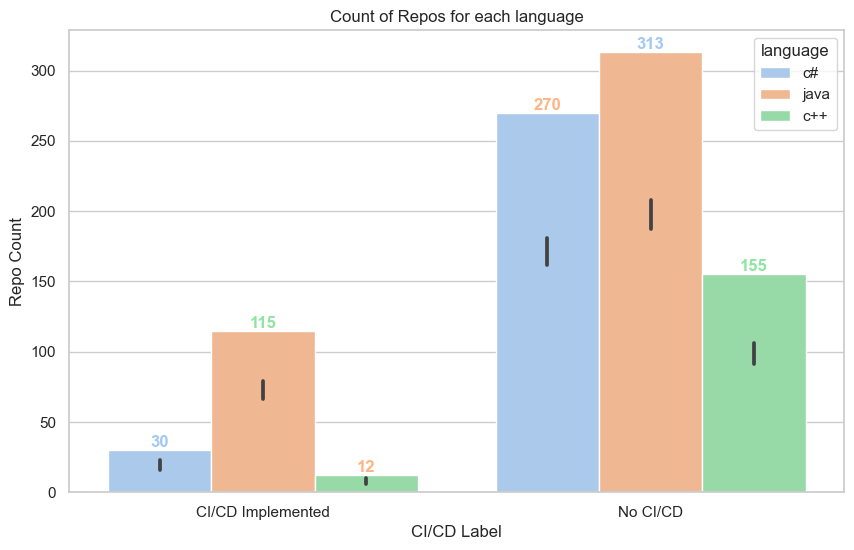

<Figure size 640x480 with 0 Axes>

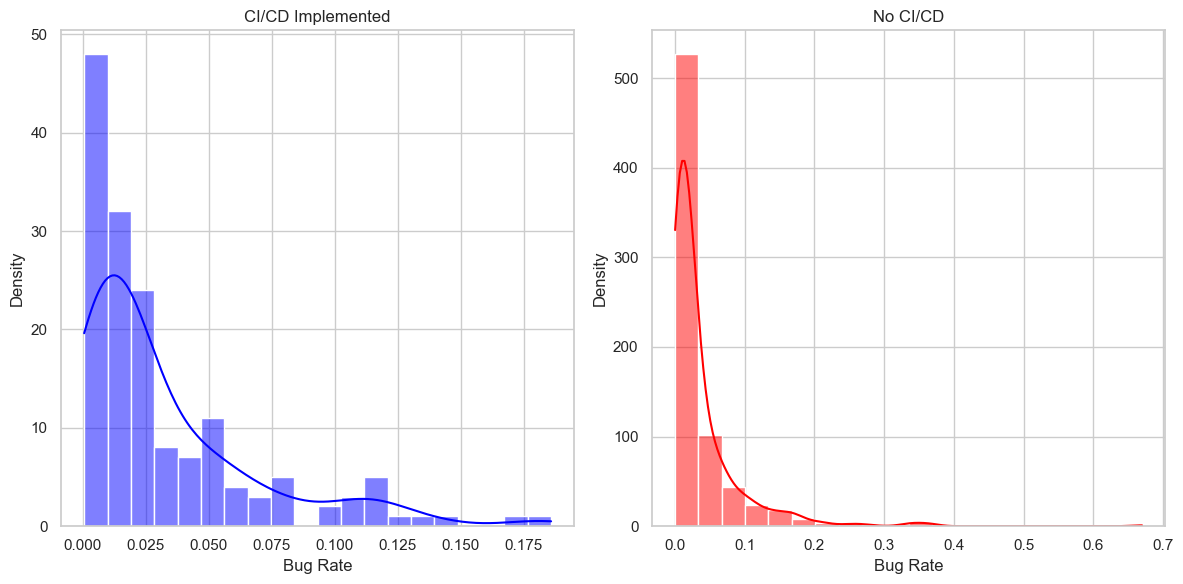

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  157.000000   157.000000    157.000000
mean     0.032257    21.770701   1572.369427
std      0.036582    39.396224   3512.567856
min      0.000500     1.000000     10.000000
25%      0.008100     2.000000    114.000000
50%      0.018500     6.000000    371.000000
75%      0.043900    22.000000   1509.000000
max      0.185900   253.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  738.000000   738.000000    738.000000
mean     0.036188    12.995935    694.178862
std      0.056525    58.847444   1496.281727
min      0.000200     1.000000     10.000000
25%      0.006400     1.000000     76.250000
50%      0.016400     3.000000    201.500000
75%      0.040000     8.000000    631.250000
max      0.670000  1368.000000  14584.000000
T-Statistic: -1.096609495433559
P-value: 0.2735966497948213
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopt

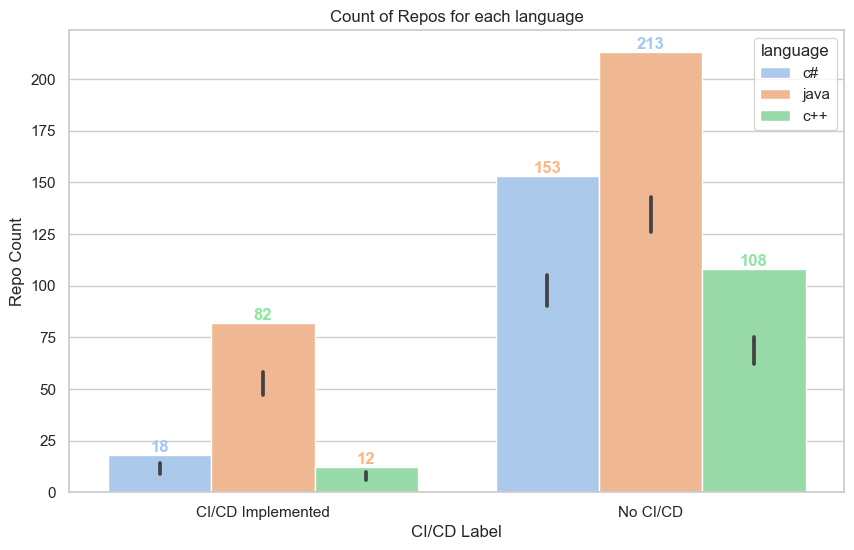

<Figure size 640x480 with 0 Axes>

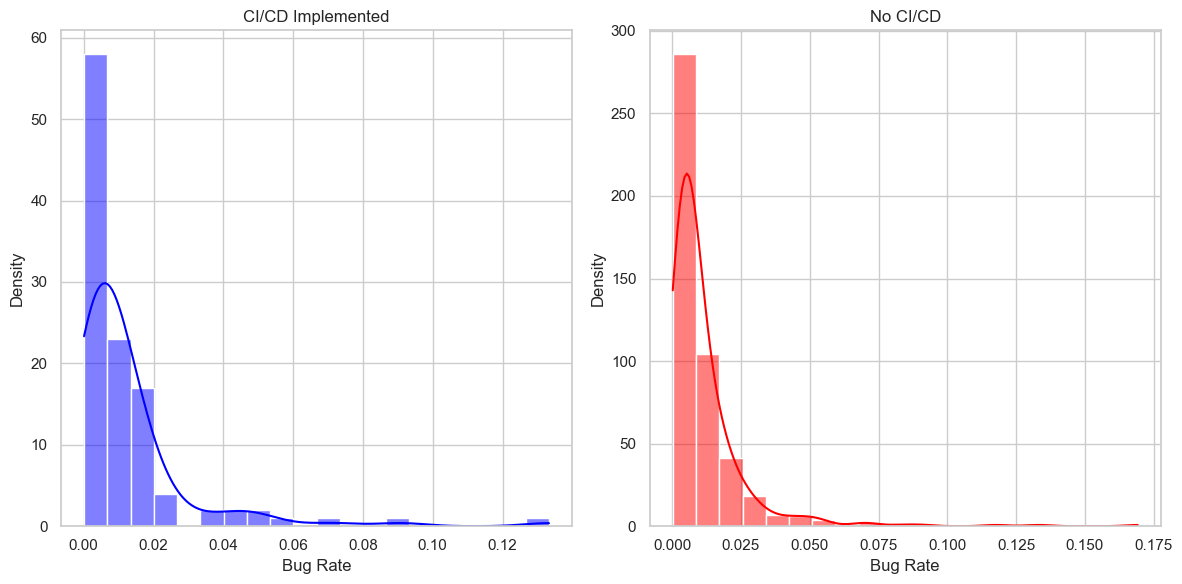

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  112.000000   112.000000    112.000000
mean     0.012310    15.080357   2111.669643
std      0.018353    36.945574   4036.337561
min      0.000100     1.000000     11.000000
25%      0.003300     1.000000    163.750000
50%      0.006400     3.000000    926.000000
75%      0.014100    11.250000   2643.750000
max      0.133300   225.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  474.000000   474.000000    474.000000
mean     0.011414     5.763713    991.666667
std      0.015807    13.223045   1786.036347
min      0.000200     1.000000     11.000000
25%      0.003425     1.000000    137.000000
50%      0.006800     2.000000    406.500000
75%      0.013175     4.000000   1005.250000
max      0.169200   146.000000  14584.000000
T-Statistic: 0.4767450688518369
P-value: 0.6342273342373044
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopt

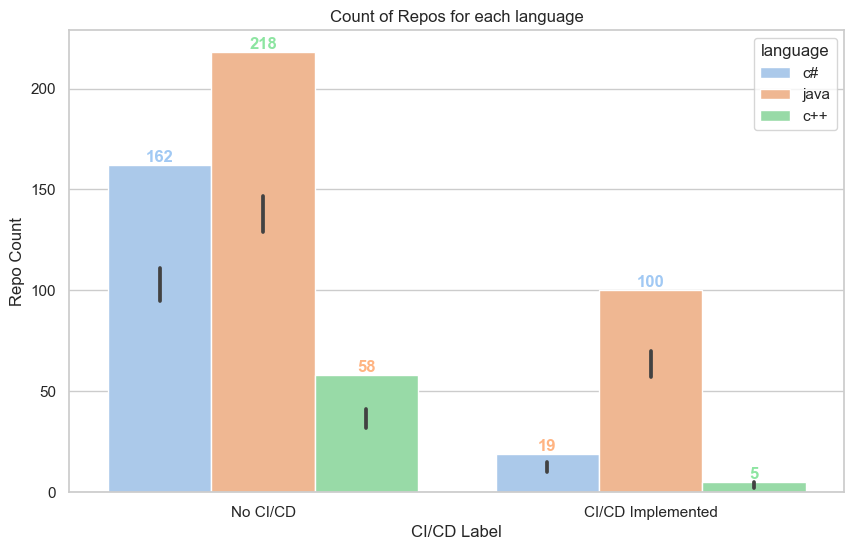

<Figure size 640x480 with 0 Axes>

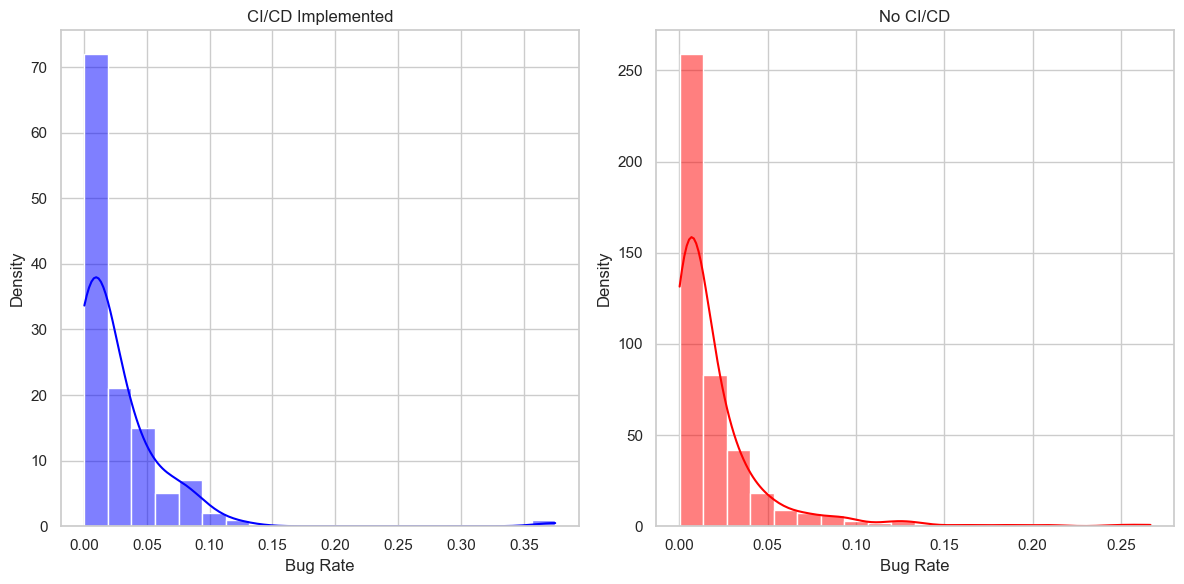

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  124.000000   124.000000    124.000000
mean     0.026443     8.887097   1397.120968
std      0.041457    23.723067   3366.072135
min      0.000300     1.000000     11.000000
25%      0.002775     1.000000     76.250000
50%      0.012400     2.500000    213.000000
75%      0.034150     6.000000   1219.250000
max      0.375000   196.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  438.000000   438.000000    438.000000
mean     0.019936     4.771689    921.714612
std      0.031264     8.791140   1823.535984
min      0.000100     1.000000     10.000000
25%      0.003300     1.000000     99.250000
50%      0.009050     2.000000    286.000000
75%      0.023400     5.000000    814.250000
max      0.266700    99.000000  14584.000000
T-Statistic: 1.622020455296035
P-value: 0.10671289343397743
Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopt

In [24]:
categories = pd.read_sql_query("""
                  SELECT distinct repeated_category 
                  From commit_message_category
                  WHERE repeated_category <> 'Others' ;
                """, connection)['repeated_category'].unique().tolist()
count = 1;
BOLD = '\033[1m'
BLUE = '\033[94m'
RESET = '\033[0m' 
for cat in categories:
    print('='*75)
    print(f'{BOLD}{BLUE}{count}: started for {cat}{RESET}')
    rq3_query = """
                SELECT bug.repo_id, bug.langauge, bug.num_collaborators, bug.has_ci_cd, 
                bug.num_bug_fix , message.num_commits ,
                bug.num_bug_fix / message.num_commits bug_rate
                FROM (
                        SELECT r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd,COUNT(c.all_category) num_bug_fix
                        FROM repositories r
                        INNER JOIN commit_message_category c
                            ON r.repo_id = c.repo_id
                        WHERE c.repeated_category = '{}'
                        GROUP BY r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd
                ) bug
                INNER JOIN (
                        SELECT repo_id,  COUNT(messages) num_commits
                        FROM commit_messages
                        WHERE  messages REGEXP '^[A-Za-z0-9[:space:][:punct:]]*$'
                        GROUP BY repo_id
                ) message
                ON bug.repo_id = message.repo_id  
    """.format(cat)
    
    df_bug = pd.read_sql(rq3_query, connection)
    # Replace values in the DataFrame
    df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
    df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
    df_bug.rename(columns={'langauge': 'language'}, inplace=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='ci_cd_label', y='repo_id', hue='language', data=df_bug, estimator=lambda x: len(set(x)), palette='pastel')
    plt.xlabel('CI/CD Label')
    plt.ylabel('Repo Count')
    plt.title('Count of Repos for each language')

    # Annotate count values on top of each bar
    for i, p in enumerate(ax.patches):
        hue_index = i % len(df_bug['language'].unique())
        plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.1, str(int(p.get_height())), ha='center', va='bottom', fontweight='bold', color=sns.color_palette('pastel')[hue_index])

    plt.xticks(rotation=0)
    # plt.tight_layout
    plt.savefig(f'Bug_Repo_Count_{cat}.jpeg')
    plt.show()

    plt.clf()

    ci_cd_implemented = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
    no_ci_cd = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

    # Plotting separate graphs
    plt.figure(figsize=(12, 6))

    # Plot for CI/CD Implemented
    plt.subplot(1, 2, 1)
    sns.histplot(ci_cd_implemented['bug_rate'], bins=20, color='blue', kde=True)
    plt.xlabel('Bug Rate')
    plt.ylabel('Density')
    plt.title('CI/CD Implemented')

    # Plot for No CI/CD
    plt.subplot(1, 2, 2)
    sns.histplot(no_ci_cd['bug_rate'], bins=20, color='red', kde=True)
    plt.xlabel('Bug Rate')
    plt.ylabel('Density')
    plt.title('No CI/CD')

    plt.tight_layout()
    plt.savefig(f'Bug_Distribution_{cat}.jpeg')
    plt.show()
    
    print('='*75)
    print(f'{BOLD}{BLUE}CI/CD Implemented{RESET}')
    print(ci_cd_implemented[['bug_rate','num_bug_fix','num_commits']].describe())

    print(f'{BOLD}{BLUE}No CI/CD{RESET}')
    print(no_ci_cd[['bug_rate','num_bug_fix','num_commits']].describe())
    print('='*75)

    ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
    no_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(ci_cd_group['bug_rate'], no_ci_cd_group['bug_rate'], equal_var=False)

    # Print results
    print("T-Statistic:", t_stat)
    print("P-value:", p_value)

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis. There is A significant difference in bug rates between CI/CD adopted and non-adopted repositories.")
    else:
        print("Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopted and non-adopted repositories.")

    print(f'{BOLD}:: Done for overall ::{RESET}')


    # Define the list of language columns
    language_columns = df_bug['language'].unique().tolist()  # Add all language columns

    df_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
    df_no_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

    # Iterate through each language column
    for language_column in language_columns:
        print('-'*50)
        ci_cd_group = df_ci_cd_group[df_ci_cd_group['language'] == language_column]
        no_ci_cd_group = df_no_ci_cd_group[df_no_ci_cd_group['language'] == language_column]
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(ci_cd_group['bug_rate'], no_ci_cd_group['bug_rate'], equal_var=False)

        # Print results
        print("Language:", language_column)
        print("T-Statistic:", t_stat)
        print("P-value:", p_value)

        # Interpret the results
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis. There is A significant difference in bug rates between CI/CD adopted and non-adopted repositories for language", language_column)
        else:
            print("Fail to reject the null hypothesis. There is NO significant difference in bug rates between CI/CD adopted and non-adopted repositories for language", language_column)

        
        
    
    print(f'finished for {cat}')
    print('='*75)
    count = count + 1

#### Conclusion based on All Language:

1. 

1: started for Integration Errors


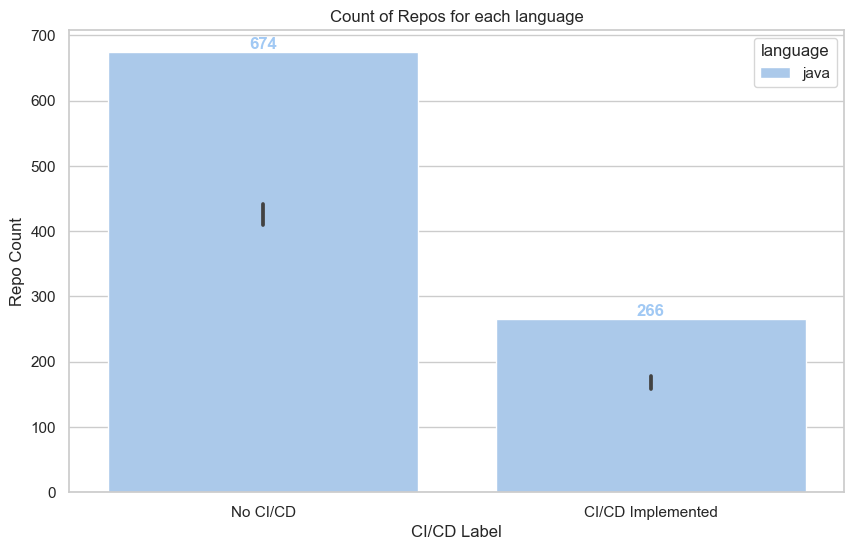

<Figure size 640x480 with 0 Axes>

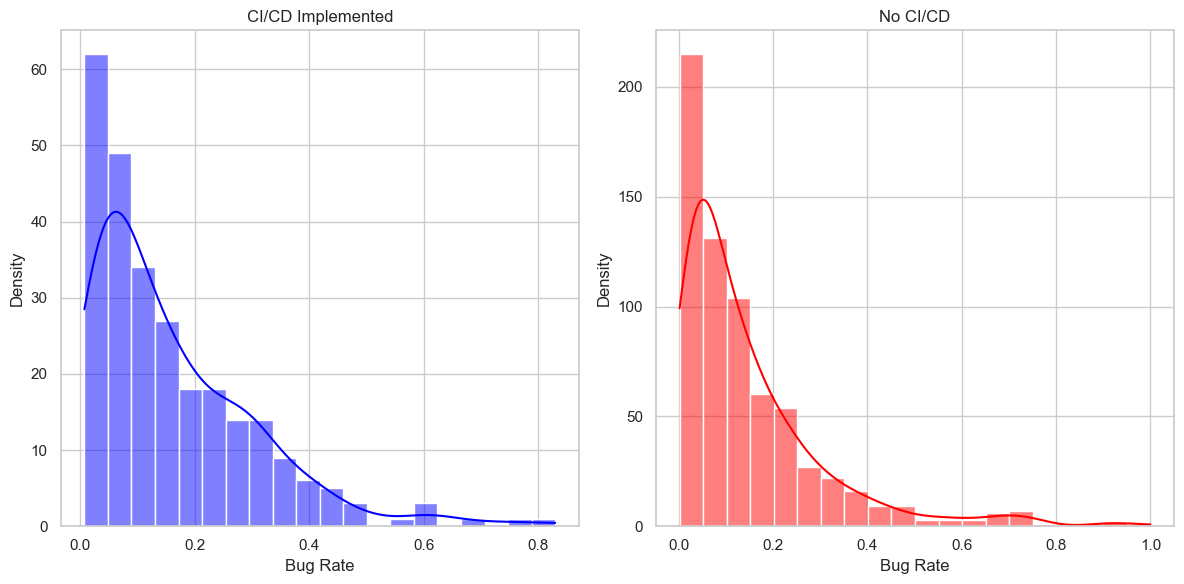

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  266.000000   266.000000    266.000000
mean     0.159888   124.951128    684.894737
std      0.144196   458.795553   2348.878222
min      0.006900     1.000000      5.000000
25%      0.050325     2.000000     39.500000
50%      0.117650    10.000000    106.000000
75%      0.240200    51.500000    355.500000
max      0.829300  4977.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  674.000000   674.000000    674.000000
mean     0.146239    72.980712    471.535608
std      0.156266   233.285993   1106.729597
min      0.002200     1.000000      2.000000
25%      0.041700     3.000000     55.000000
50%      0.096350    10.000000    124.000000
75%      0.200000    41.000000    382.750000
max      1.000000  3183.000000  11005.000000
T-Statistic: 1.2761291715493812
P-value: 0.20247593812341683
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adop

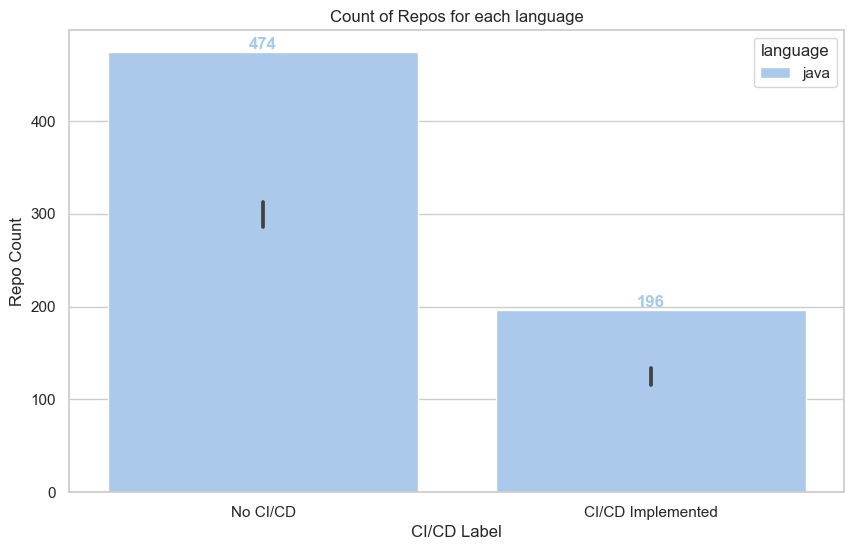

<Figure size 640x480 with 0 Axes>

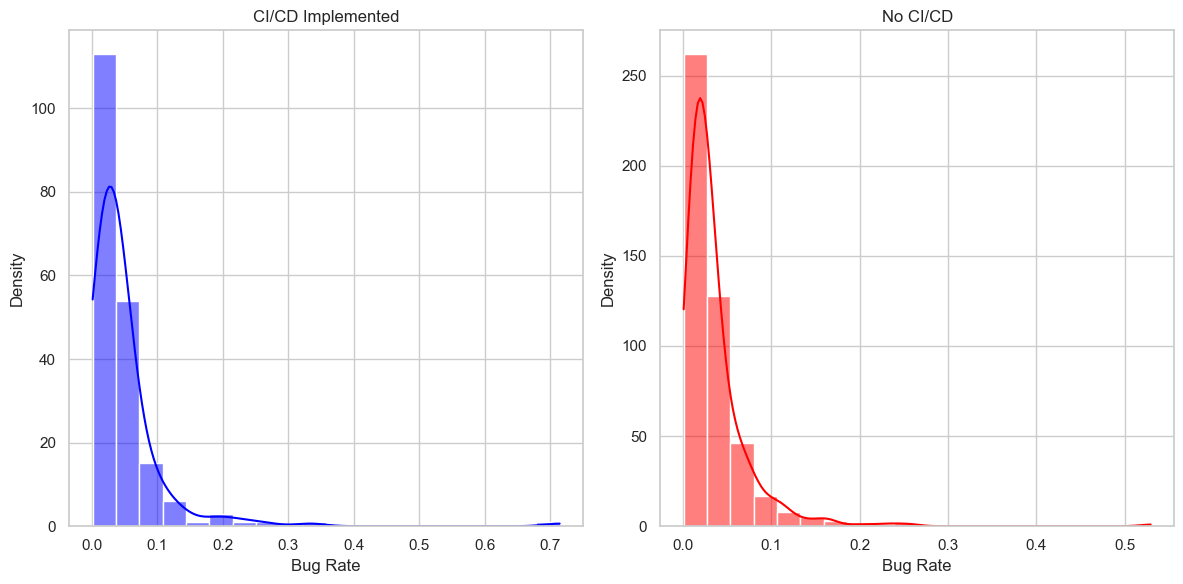

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  196.000000   196.000000    196.000000
mean     0.047127    31.816327    915.326531
std      0.066805   120.227421   2718.423726
min      0.001300     1.000000      8.000000
25%      0.016200     1.000000     46.500000
50%      0.031200     4.000000    160.500000
75%      0.050300    14.250000    520.000000
max      0.714300  1448.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  474.000000   474.000000    474.000000
mean     0.035738    16.723629    633.172996
std      0.040808    34.283077   1283.992546
min      0.001000     1.000000     15.000000
25%      0.014525     2.000000     81.250000
50%      0.024750     5.000000    194.000000
75%      0.040700    14.000000    563.500000
max      0.529400   311.000000  11005.000000
T-Statistic: 2.221429339744696
P-value: 0.027192500625325484
Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and n

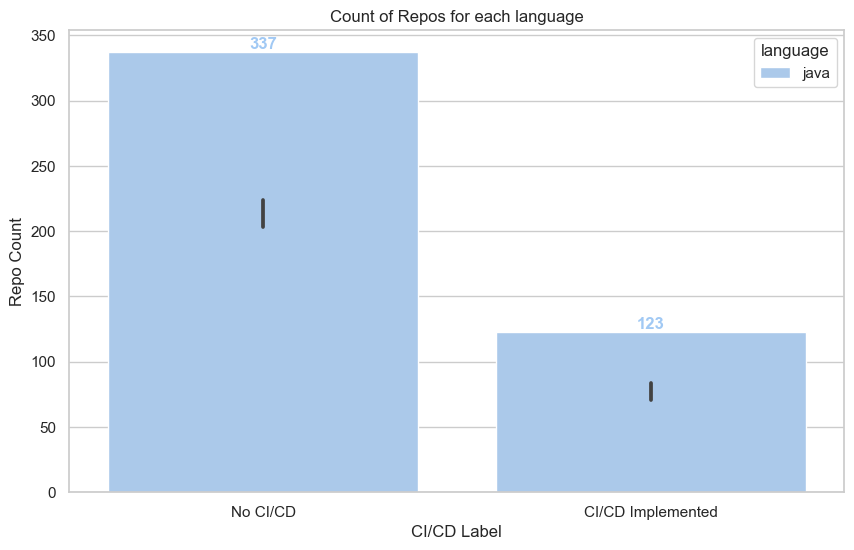

<Figure size 640x480 with 0 Axes>

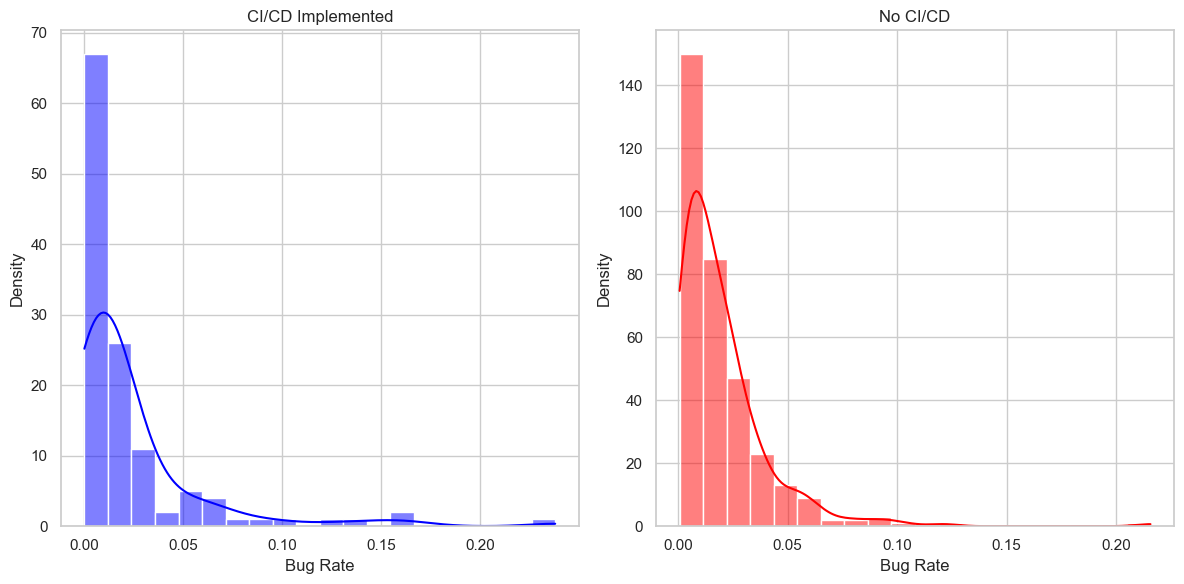

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  123.000000   123.000000    123.000000
mean     0.023576    12.764228   1382.845528
std      0.036041    32.579054   3346.522426
min      0.000200     1.000000      8.000000
25%      0.005550     1.000000    102.500000
50%      0.010300     3.000000    291.000000
75%      0.023650     8.000000   1196.500000
max      0.238100   281.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  337.000000   337.000000    337.000000
mean     0.019728     8.718101    795.738872
std      0.021451    18.274545   1479.836487
min      0.000700     1.000000     20.000000
25%      0.006200     1.000000     97.000000
50%      0.014000     3.000000    240.000000
75%      0.025900     8.000000    717.000000
max      0.215600   163.000000  11005.000000
T-Statistic: 1.114241658261925
P-value: 0.266904238778952
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adopted

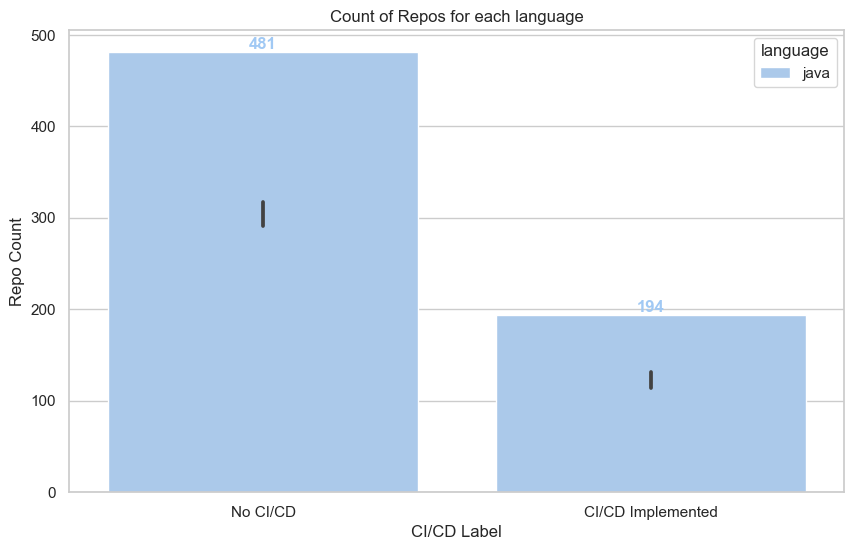

<Figure size 640x480 with 0 Axes>

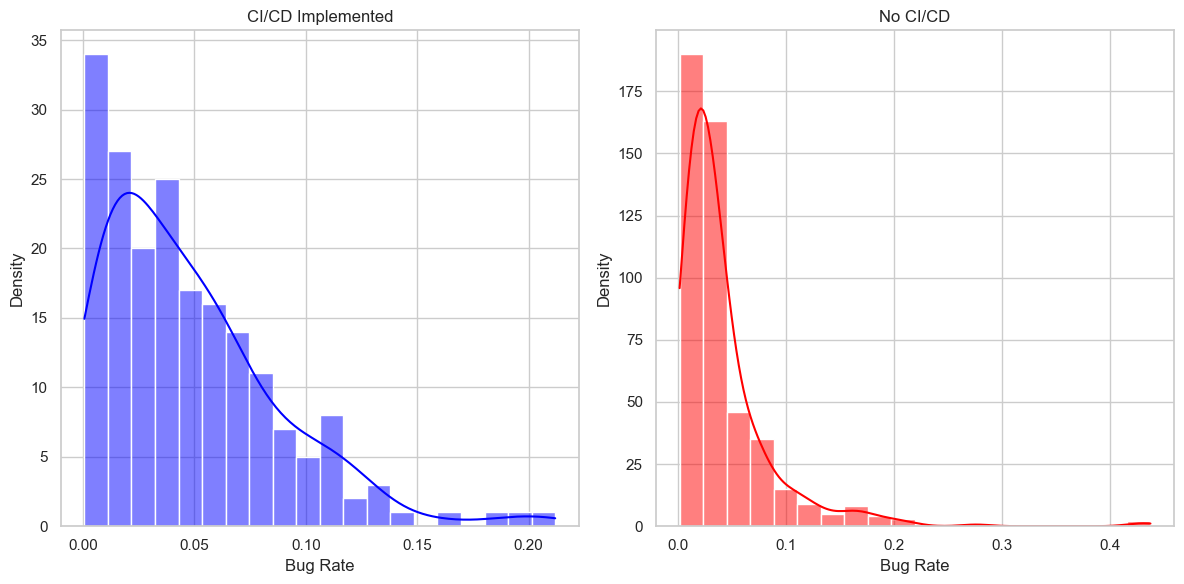

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  194.000000   194.000000    194.000000
mean     0.047964    34.855670    923.871134
std      0.039497   111.953959   2731.176241
min      0.000600     1.000000      7.000000
25%      0.017050     2.000000     51.000000
50%      0.039750     4.000000    162.000000
75%      0.065750    16.000000    508.750000
max      0.211900  1256.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  481.000000   481.000000    481.000000
mean     0.041201    22.841996    623.270270
std      0.046324    53.422256   1276.416426
min      0.001200     1.000000     13.000000
25%      0.014600     2.000000     83.000000
50%      0.027400     4.000000    186.000000
75%      0.048200    18.000000    552.000000
max      0.437500   554.000000  11005.000000
T-Statistic: 1.9126289732619923
P-value: 0.056483320494508625
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD ado

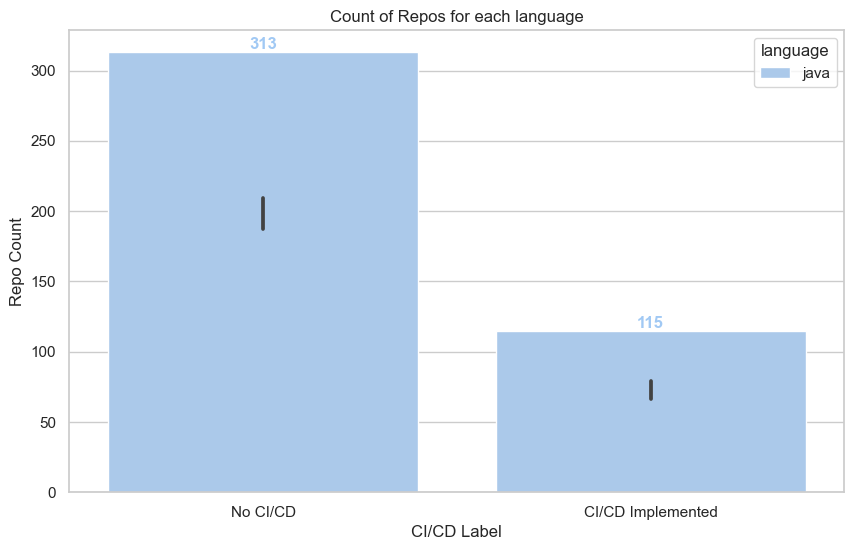

<Figure size 640x480 with 0 Axes>

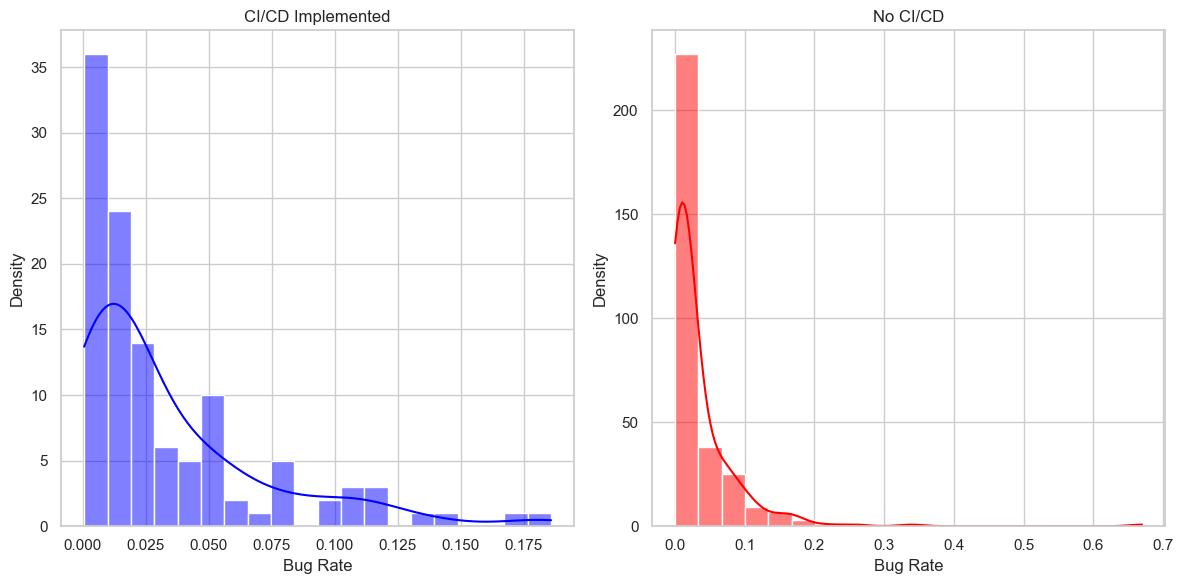

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  115.000000   115.000000    115.000000
mean     0.033510    20.017391   1452.060870
std      0.038424    36.892918   3451.010158
min      0.000500     1.000000     10.000000
25%      0.007500     1.000000     98.000000
50%      0.018300     5.000000    340.000000
75%      0.048550    17.500000   1302.000000
max      0.185900   253.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  313.000000   313.000000    313.000000
mean     0.033630    12.690096    847.923323
std      0.057117    30.818271   1525.118552
min      0.000200     1.000000     12.000000
25%      0.005000     1.000000     95.000000
50%      0.013600     3.000000    281.000000
75%      0.037000    10.000000    798.000000
max      0.670000   368.000000  11005.000000
T-Statistic: -0.024863751698630452
P-value: 0.9801800823152103
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD ad

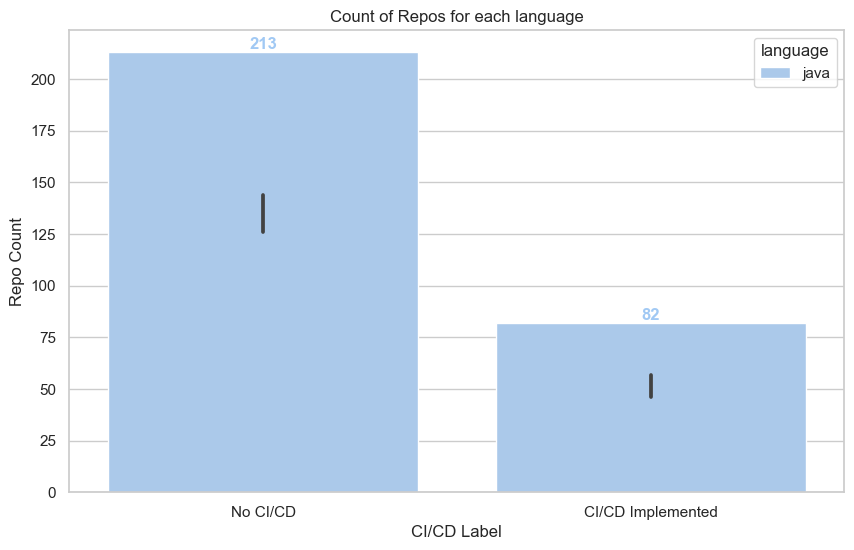

<Figure size 640x480 with 0 Axes>

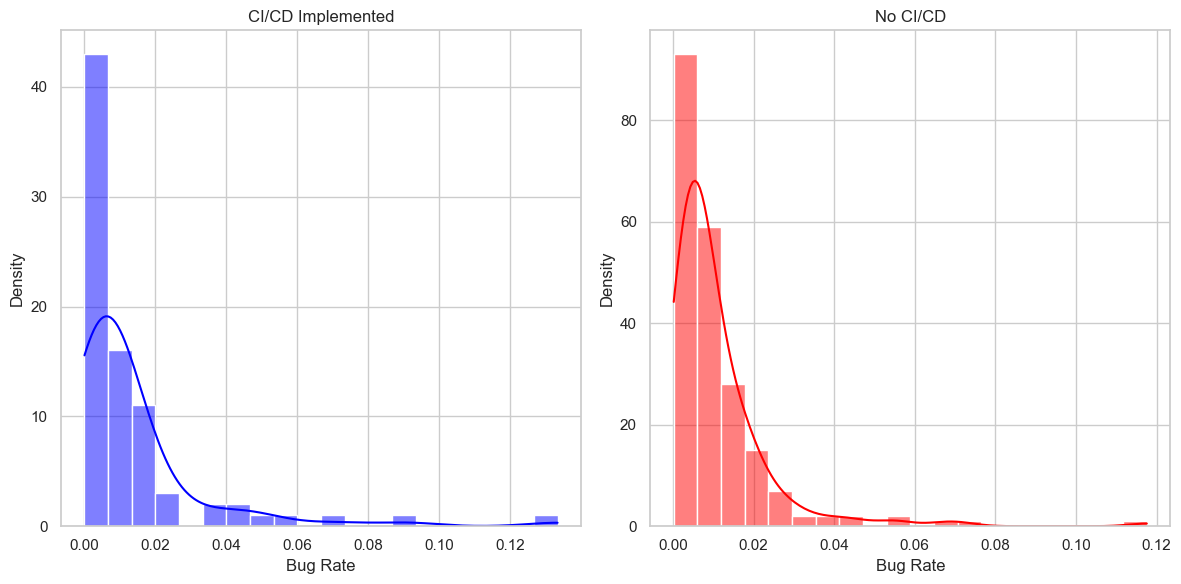

CI/CD Implemented
        bug_rate  num_bug_fix   num_commits
count  82.000000    82.000000     82.000000
mean    0.013454    12.048780   1944.219512
std     0.020586    29.989258   3983.666256
min     0.000100     1.000000     11.000000
25%     0.003425     1.000000    142.000000
50%     0.006400     3.000000    556.000000
75%     0.013950    10.000000   1878.750000
max     0.133300   191.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  213.000000   213.000000    213.000000
mean     0.010773     6.990610   1164.431925
std      0.013131    12.383415   1756.076470
min      0.000200     1.000000     14.000000
25%      0.003600     1.000000    174.000000
50%      0.006800     3.000000    516.000000
75%      0.013100     7.000000   1127.000000
max      0.117600    84.000000  11005.000000
T-Statistic: 1.0963144962106792
P-value: 0.2753943220917386
Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adopted and no

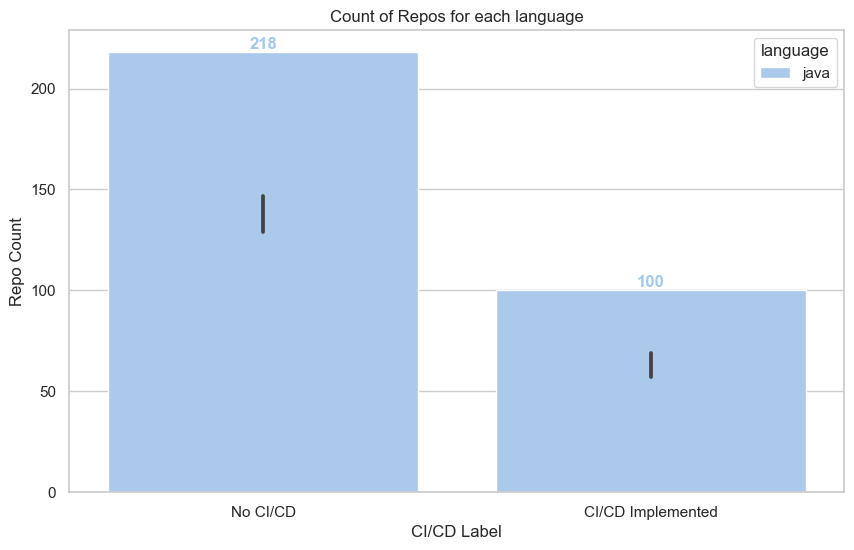

<Figure size 640x480 with 0 Axes>

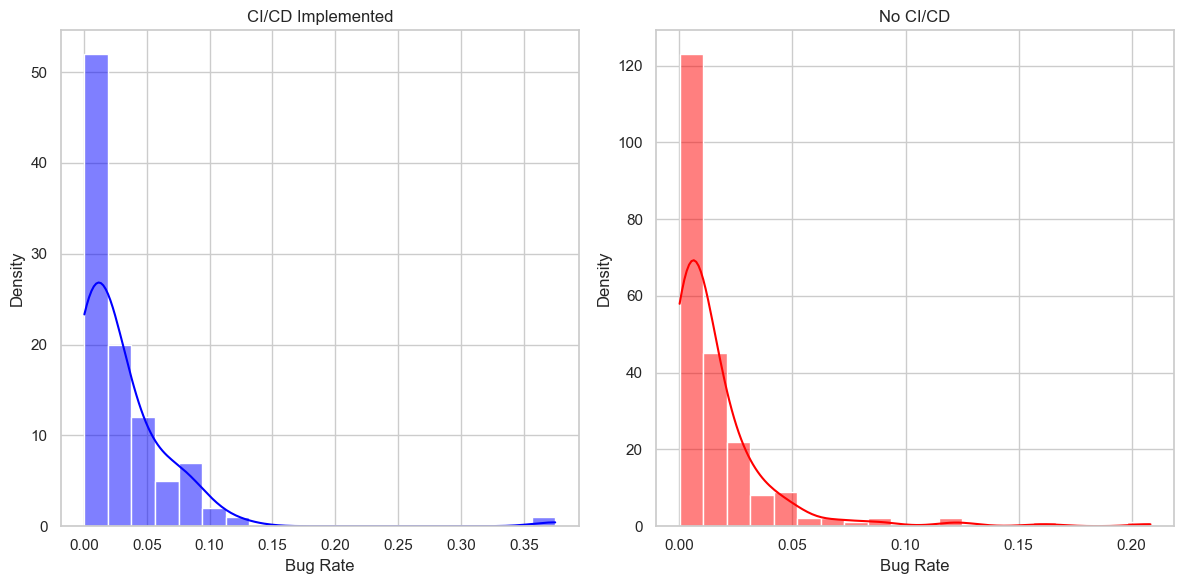

CI/CD Implemented
         bug_rate  num_bug_fix   num_commits
count  100.000000   100.000000    100.000000
mean     0.030043     9.740000   1351.410000
std      0.044937    26.114596   3595.395813
min      0.000300     1.000000     11.000000
25%      0.004525     1.000000     64.000000
50%      0.016800     2.000000    163.000000
75%      0.042150     5.250000    979.500000
max      0.375000   196.000000  30621.000000
No CI/CD
         bug_rate  num_bug_fix   num_commits
count  218.000000   218.000000    218.000000
mean     0.016184     4.669725   1007.857798
std      0.025017     7.361070   1714.962778
min      0.000100     1.000000     24.000000
25%      0.002600     1.000000    114.000000
50%      0.007650     2.000000    364.000000
75%      0.018875     5.000000    940.500000
max      0.208300    60.000000  11005.000000
T-Statistic: 2.8856675960928584
P-value: 0.0045854960622768335
Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and

In [25]:
categories = pd.read_sql_query("""
                  SELECT distinct repeated_category 
                  From commit_message_category
                  WHERE repeated_category <> 'Others' ;
                """, connection)['repeated_category'].unique().tolist()
count = 1; 
for cat in categories:
    print('='*75)
    print(f'{BOLD}{BLUE}{count}: started for {cat}{RESET}')
    rq3_query = """
                SELECT bug.repo_id, bug.langauge, bug.num_collaborators, bug.has_ci_cd, 
                bug.num_bug_fix , message.num_commits ,
                bug.num_bug_fix / message.num_commits bug_rate
                FROM (
                        SELECT r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd,COUNT(c.all_category) num_bug_fix
                        FROM repositories r
                        INNER JOIN commit_message_category c
                            ON r.repo_id = c.repo_id
                        WHERE c.repeated_category = '{}'
                            AND r.langauge = 'java'
                        GROUP BY r.repo_id, r.langauge, r.num_collaborators, r.has_ci_cd
                ) bug
                INNER JOIN (
                        SELECT repo_id,  COUNT(messages) num_commits
                        FROM commit_messages
                        WHERE  messages REGEXP '^[A-Za-z0-9[:space:][:punct:]]*$'
                        GROUP BY repo_id
                ) message
                ON bug.repo_id = message.repo_id  
    """.format(cat)
    
    df_bug = pd.read_sql(rq3_query, connection)
    # Replace values in the DataFrame
    df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
    df_bug['ci_cd_label'] = df_bug['has_ci_cd'].replace(label_map)
    df_bug.rename(columns={'langauge': 'language'}, inplace=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='ci_cd_label', y='repo_id', hue='language', data=df_bug, estimator=lambda x: len(set(x)), palette='pastel')
    plt.xlabel('CI/CD Label')
    plt.ylabel('Repo Count')
    plt.title('Count of Repos for each language')

    # Annotate count values on top of each bar
    for i, p in enumerate(ax.patches):
        hue_index = i % len(df_bug['language'].unique())
        plt.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.1, str(int(p.get_height())), ha='center', va='bottom', fontweight='bold', color=sns.color_palette('pastel')[hue_index])

    plt.xticks(rotation=0)
    # plt.tight_layout
    plt.savefig(f'Bug_Repo_Count_{cat}.jpeg')
    plt.show()

    plt.clf()

    ci_cd_implemented = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
    no_ci_cd = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

    # Plotting separate graphs
    plt.figure(figsize=(12, 6))

    # Plot for CI/CD Implemented
    plt.subplot(1, 2, 1)
    sns.histplot(ci_cd_implemented['bug_rate'], bins=20, color='blue', kde=True)
    plt.xlabel('Bug Rate')
    plt.ylabel('Density')
    plt.title('CI/CD Implemented')

    # Plot for No CI/CD
    plt.subplot(1, 2, 2)
    sns.histplot(no_ci_cd['bug_rate'], bins=20, color='red', kde=True)
    plt.xlabel('Bug Rate')
    plt.ylabel('Density')
    plt.title('No CI/CD')

    plt.tight_layout()
    plt.savefig(f'Bug_Distribution_{cat}.jpeg')
    plt.show()
    
    print('='*75)
    print(f'{BOLD}{BLUE}CI/CD Implemented{RESET}')
    print(ci_cd_implemented[['bug_rate','num_bug_fix','num_commits']].describe())

    print(f'{BOLD}{BLUE}No CI/CD{RESET}')
    print(no_ci_cd[['bug_rate','num_bug_fix','num_commits']].describe())
    print('='*75)

    

#     ci_cd_shapiro = stats.shapiro(ci_cd_implemented['bug_rate'])
#     no_ci_cd_shapiro = stats.shapiro(no_ci_cd['bug_rate'])

#     print("Shapiro-Wilk Test p-value for CI/CD Implemented:", ci_cd_shapiro[1])
#     print("Shapiro-Wilk Test p-value for No CI/CD:", no_ci_cd_shapiro[1])

    ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'CI/CD Implemented']
    no_ci_cd_group = df_bug[df_bug['ci_cd_label'] == 'No CI/CD']

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(ci_cd_group['bug_rate'], no_ci_cd_group['bug_rate'], equal_var=False)

    # Print results
    print("T-Statistic:", t_stat)
    print("P-value:", p_value)

    # Interpret the results
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference in bug rates between CI/CD adopted and non-adopted repositories.")
    else:
        print("Fail to reject the null hypothesis. There is no significant difference in bug rates between CI/CD adopted and non-adopted repositories.")

    print(f'{BOLD}:: Done for overall ::{RESET}')
    
    print(f'finished for {cat}')
    print('='*75)
    count = count + 1

In [26]:
connection.close()